### Counterfactual: Change parameters.

#### This files looks at what would happen if we change the tax notch and tax break.

#### By Phil Huang

In [1]:
import pandas as pd
import numpy as np
import random
import math
import copy
from matplotlib import pyplot as plt 
from copulas.datasets import sample_trivariate_xyz
from copulas.visualization import scatter_3d, compare_3d
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import BetaUnivariate, GaussianKDE, GaussianUnivariate
from scipy.stats import pareto, beta
from fitter import Fitter, get_common_distributions, get_distributions
from scipy import optimize
from scipy.optimize import fsolve
from scipy.optimize import minimize, rosen, rosen_der
from scipy import stats
import statsmodels.api as sm
from datetime import datetime
%matplotlib inline

start_time1 = datetime.now()

In [2]:
# specify the path
path  = '/Users/philhuang/Desktop/FDI/workingdata/'
figure_path = '/Users/philhuang/Desktop/FDI/figure/'

#### Type in some functions we need to solve for $\delta$ and $\eta$.

In [3]:
# Eqaution 8 where we calculate optimal beta.
def get_optimal_beta(sigma, eta):
    part1     = eta/(1-eta)
    part2     = 1-(sigma-1)*(1-eta)/sigma 
    part3     = 1- (sigma-1)*eta/sigma 
    temp      = np.sqrt(part1*part2/part3)
    beta_star = temp/(1+temp)
    return beta_star

# From (8), we solve for eta given beta. We need to use binary search.
# First, we define a function with which we get the value which is closer to the target.
# when we have two candidates RHS_vals[a]<RHS_vals[b], which means the a_th RHS value smaller than the target 
# and the b_th RHS values bigger than the target.

def get_closer_num(lst,a,b,target):
    baseline = abs(lst[a]-target)
    if abs(lst[b]-target) <= baseline:
        return b
    else:
        return a

# Then we define a binary search function to solve the function.
# In general, lst_a contains the target we want to search for, and we want to return the corresponding 
# element in lst_b
def get_ans(lst_a, lst_b, target):
    
    left=0 
    right=len(lst_a)
    
    while left<right:
        middle = left+ ((right - left)//2)
        if lst_a[middle] == target:
            return lst_b[middle]
        if lst_a[middle] < target:
            if lst_a[middle+1] >= target:
                idx_g = get_closer_num(lst_a, middle, middle+1, target)
                return lst_b[idx_g]
            else:
                left = middle+1
        if lst_a[middle] > target:
            if lst_a[middle-1] <= target:
                idx_g = get_closer_num(lst_a, middle-1, middle, target)
                return lst_b[idx_g]
            else:
                right = middle

# Equation 7. Given sigma, eta and beta, we get delta. 
# Note that since beta* is a function of sigma and eta, delta is a function of sigma and eta too. 
def get_delta(sigma, eta, beta):
    part1 = sigma - (sigma-1)*(beta*eta+(1-beta)*(1-eta))
    part2 = (((1/beta)**eta) * ((1/(1-beta))**(1-eta)))**(1-sigma)
    delta = part1*part2
    return delta

# define a function to calculate omega used in the counterfactuals.
def get_Omega(sigma, eta, beta):
    part1 = (1/beta)**eta
    part2 = (1/(1-beta))**(1-eta)
    Omega = (part1*part2)**(1-sigma)
    return Omega

# Input equation (15-19)
def get_FirmVar(beta, eta, sigma, wh, wm, tau, varphi, P, X, bunch_or_not, cost):
    
    p_star  = (sigma/(sigma-1))* ((wh/eta)**eta) * ((wm/(1-eta))**(1-eta)) /varphi
    p_tild  = (sigma/(sigma-1)) * (wh/(beta*eta))**eta * (wm/((1-beta)*(1-eta)))**(1-eta) / varphi
    x_tild  = p_tild**(1-sigma) * P**(sigma-1) * X * (1-tau)**sigma
    h_tild  = ((sigma-1)/sigma) * (beta*eta/wh) * x_tild
    m_tild  = ((sigma-1)/sigma) * ((1-beta)*(1-eta)/wm) * x_tild
    
    # Note that if ther is no bunching (bunch_or_not == 1), the final Pi is just Pi_tild.
    # If there is bunching (bunch_or_not == 0), then the final Pi should deduct the cost.
    pi_tild = (get_delta(sigma, eta, beta)-cost*(1-bunch_or_not))* p_star**(1-sigma) * P**(sigma-1)* X*((1-tau)**sigma)/sigma

    return p_tild, x_tild, h_tild, m_tild, pi_tild
    #return pi_tild


### P1. Generate distribution of intensity and productivity we need.

In [4]:
# We read in bins (beta), eta data and see their distributions. 
beta_eta_df   = pd.read_csv(path+'beta_eta.csv')
beta_all      = np.array(beta_eta_df['beta_bins'])
eta_all       = np.array(beta_eta_df['eta_bins'])

# Read in bins, real distribution and counterfactual distributions of firms we use in the bunching estimation.
bunching_df   = pd.read_excel(path+'R2_pre2008June122023.xlsx')
bunching_df

bins_bunching = np.array(bunching_df['R2_bins'])
C_bunching    = np.array(bunching_df['R2_C_all'])  # Actual probability of firms falling into each bins.
h_bunching    = np.array(bunching_df['h'])         # Counterfactual probability of firms falling into each bins.

bunching_para = pd.read_excel(path+'R4_pre2008June122023.xlsx')
p             = np.int32(np.array(bunching_para['p'])[0])                                 # Polynomial.
minD          = np.float64(np.array(bunching_para['minD'])[0])                             # Minimum of the bins we use.

tau_L         = np.float64(0.15)
tau_H         = np.float64(0.225)

w_h           = 1
w_m           = 1
big_p         = 1
big_x         = 1

# Read in the parameters we calibrated.
final_paras = pd.read_csv(path+'calibration_rstJune122023.csv')
sigma, theta, k, mu_c = np.array(final_paras)[0,:]
print(sigma, theta, k, mu_c)

# Read in b that we estimated from the bunching part.
b = np.array(pd.read_excel(path+'R5_pre2008June122023.xlsx')['b'])


2.346160352519226 20.05298080521329 2.151907030827452 0.3203391475285694


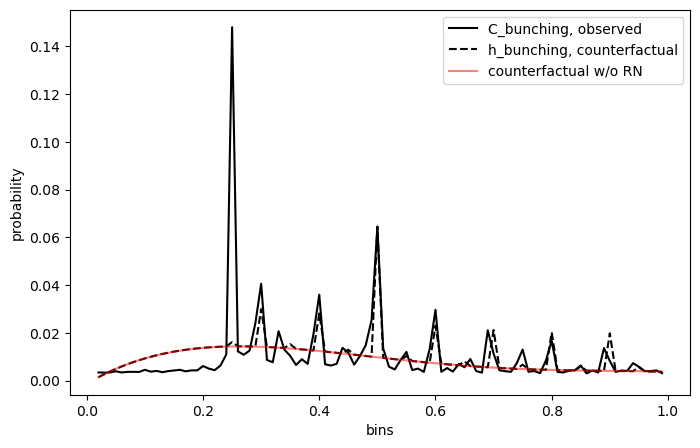

In [5]:
# Now we want to get the distribution of eta. 
# In order to do so, we omit all the round number effects. 
polynomial_beta = []
for i in range(p+1):
    polynomial_beta.append(bins_bunching**i)
polynomial_beta = np.array(polynomial_beta).T

# Multiply b and polynomial_beta together.
distribution_noRN = np.dot(polynomial_beta, b[:p+1].reshape(p+1,-1))
distribution_noRN = distribution_noRN.ravel()

# Plot the distribution.
fig1, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
ax.plot(bins_bunching, C_bunching, linestyle='solid', c='k', linewidth=1.5, label='C_bunching, observed')
ax.plot(bins_bunching, h_bunching, linestyle='--', c='k', linewidth=1.5, label='h_bunching, counterfactual')
ax.plot(bins_bunching, distribution_noRN, linestyle='solid', alpha=0.5, c='r', 
        linewidth=1.5, label='counterfactual w/o RN')
ax.set(xlabel='bins', ylabel='probability')
ax.legend()

In [6]:
# Now we simulate 100,000 firms. 
# The first step is to generate 100,000 betas according to the counterfactual distribution of Beta.
# Now we know the probability of etas falling into each bins, we simulate data of eta based on this.
# cf means counterfactual here.
beta_cf_simul = []
# We cut the last bin (0.99-1) out since there would be a lot of extrem values in that bin when we calculate eta.
bins_bunching = np.array(bunching_df['R2_bins'])

# We get lower and uppper bond of each bin, and sample beta within each bin.
beta_temp  = list(bins_bunching)
beta_temp.append(np.float64(1.0))
total_firm_num = 100000

for i in range(len(beta_temp)-1):
    lb_bin  = beta_temp[i]     # lower bond of the bin
    ub_bin  = beta_temp[i+1]   # upper bond of the bin 
    len_bin = ub_bin-lb_bin
    
    # Number of firms in each bin, each should have an eta that lies within the range of the bin. 
    # Here we assume that in each bin, eta is uniformly distributed.
    bin_firm_num = int(h_bunching[i]*total_firm_num)
    np.random.seed(123+i)
    
    # Random.random_sample generates uniformly-distributed sample in [0,1). So here we need to multiply them
    # by the length of each bin, and add lb_bin to it. 
    rand_uniform   = np.random.random_sample(size = bin_firm_num)
    beta_each_bin  = list(rand_uniform*len_bin + lb_bin)
    beta_cf_simul += beta_each_bin

Number of simulated firms: 99277
Number of counterfactual firms: 99321
Note that there should be less than 100,000 firms since we exclude firms with fdi_share>0.99, and fdi_share less than 0.02.
There is some slight difference between the number of counterfactual and simulated firms because we round the floats to integers.


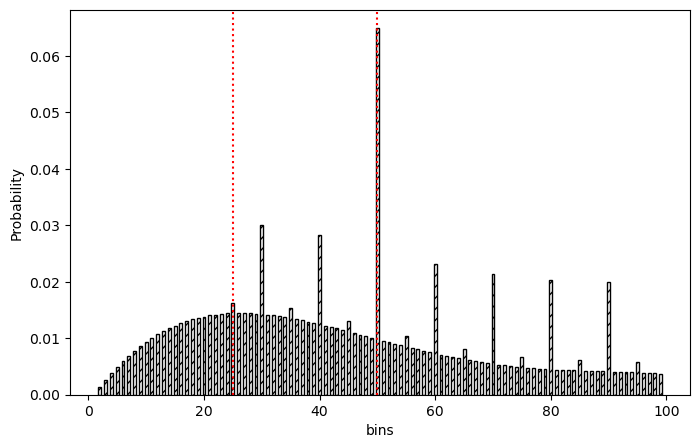

In [7]:
# Let's check how our simulated beta looks like. 
a1 = len(beta_cf_simul)
a2 = int(np.sum(h_bunching)*total_firm_num)
print('Number of simulated firms: {0}'.format(a1))
print('Number of counterfactual firms: {0}'.format(a2))
print('Note that there should be less than 100,000 firms since we exclude firms with fdi_share>0.99, and fdi_share less than 0.02.')
print('There is some slight difference between the number of counterfactual and simulated firms because we round the floats to integers.')
# Now we put all the simulated_beta_star into each bins.
bins_temp = np.arange(2,100)/100

# Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
simul_bin_id = np.digitize(beta_cf_simul, bins_temp, right=False)
simul_bin_id = simul_bin_id+1

# Count how many betas are there in each bin.
simul_beta_df      = pd.DataFrame(data={'beta_cf_simul':np.array(beta_cf_simul), 'simul_bin_id':np.array(simul_bin_id)})
simul_betaCount_df = simul_beta_df.groupby('simul_bin_id')['beta_cf_simul'].count()
simul_betaCount_df = simul_betaCount_df.reset_index()
simul_betaCount_df.rename(columns={'beta_cf_simul':'count'}, inplace=True)

# Plot the distribution. 
# Label the 25% and 50% bins.
fig2, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
ax.bar(simul_betaCount_df['simul_bin_id'], simul_betaCount_df['count']/a1, edgecolor='black', facecolor='white', hatch='///', width=0.5)
ax.set(xlabel='bins', ylabel='Probability')
ax.axvline(x=25, c='r', linestyle=':')
ax.axvline(x=50, c='r', linestyle=':')



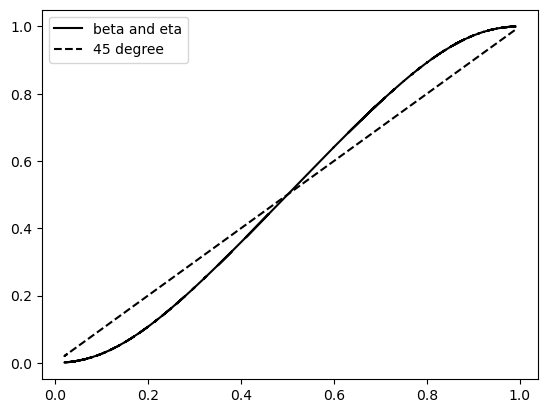

In [8]:
# Now we calculate optimal eta for these firms.
# With beta_bins, calculate the LHS of (8). This is the list of targets we are searching for. 
# Note that now when beta>0.99, there would be extreme values when we calculate eta. For simplicity, we replace
# all beta>0.99 to be 0.99.
simul_beta_df.loc[simul_beta_df['beta_cf_simul']>0.99, ['beta_cf_simul']]=0.99
beta_cf_simul = simul_beta_df['beta_cf_simul'].values
LHS_8 = np.array(beta_cf_simul)/(1-np.array(beta_cf_simul))

# Define the space of eta, which is the lst_b in the get_ans function. 
eta_space = np.linspace(0.0001, 0.9999, 1000000)

# Calculate the RHS of equation 8, which is the lst_a in the get_ans function. 
part1  = eta_space/(1-eta_space)
part2  = 1-(sigma-1)*(1-eta_space)/sigma 
part3  = 1- (sigma-1)*eta_space/sigma 
RHS_8  = np.sqrt(part1*part2/part3)

eta_simul = np.zeros(len(beta_cf_simul))

for i in range(len(beta_cf_simul)): 
    eta_simul[i] = get_ans(RHS_8, eta_space, LHS_8[i])

simul_beta_df['eta_simul'] = np.array(eta_simul)

# Let's see the relationship between beta and eta.
plt.plot(simul_beta_df['beta_cf_simul'], simul_beta_df['eta_simul'], c='k', linestyle='-', label='beta and eta')
plt.plot(simul_beta_df['beta_cf_simul'], simul_beta_df['beta_cf_simul'], c='k', linestyle='--', label='45 degree')
plt.legend()

### We decompose the change of all outputs.

In [9]:
def DecomposeOutcomeChange(theta, mu_c, k, tau_L, notch, Reps):
    # See the process of drawing these random numbers in 
    # section B.1 Online Appendix of James & Ariell (2015 CJE)
    np.random.seed(1234+Reps)
    copula_u = np.random.uniform(0,1,101310)

    np.random.seed(123+Reps)
    copula_x = np.random.uniform(0,1,101310)

    copula_a = copula_x*(1-copula_x)
    copula_b = theta + copula_a*((theta-1)**2)
    copula_c = 2*copula_a*(copula_u*(theta**2)+1-copula_u) + theta*(1-2*copula_a)
    copula_d = np.sqrt(theta)*np.sqrt(theta + 4*copula_a*copula_u*(1-copula_u)*((1-theta)**2))
    copula_v = (copula_c-(1-2*copula_x)*copula_d)/(2*copula_b)

    # We assume that cost is just a uniform distribution.
    copula_cost = copula_u*mu_c

    # Now we generate varphi based on U we draw.
    # If U is drawn from a uniform distribution [0,1], and T = xm*U**(-1/k), then T is Pareto-Distributed.
    xm = 1

    copula_varphi = xm*((1-copula_v)**(-1/k))

    cost_varphi_df = pd.DataFrame(data={'copula_cost':copula_cost, 'copula_varphi':copula_varphi})

    # Winsorize the sample. Drop the bottom 1% and top 1% sample.
    top99   = np.quantile(copula_varphi, 0.99)
    bottom1 = np.quantile(copula_varphi, 0.01)

    eta_varphi_winsorized = copy.deepcopy(cost_varphi_df[(cost_varphi_df['copula_varphi']<top99)&(cost_varphi_df['copula_varphi']>bottom1)])
    eta_varphi_winsorized.reset_index(drop=True, inplace=True)
    costVarphi_corr = np.corrcoef(eta_varphi_winsorized['copula_cost'], eta_varphi_winsorized['copula_varphi'])[0][1]

    # Compile data into a dataFrame
    sim_firm_df = pd.DataFrame(data={'beta_cf_simul': simul_beta_df['beta_cf_simul'],
                                     'simul_bin_id': simul_beta_df['simul_bin_id'],
                                     'eta_simul': simul_beta_df['eta_simul'],
                                     'cost_simul': eta_varphi_winsorized['copula_cost'][:len(simul_beta_df)],
                                     'varphi_simul': eta_varphi_winsorized['copula_varphi'][:len(simul_beta_df)]})

    # Compile tax rate before bunching. 
    sim_firm_df['tau_noBunch'] = tau_L
    sim_firm_df.loc[sim_firm_df['beta_cf_simul']<notch, ['tau_noBunch']] = tau_H

    # Outcomes without bunching (NB means no bunching).
    p_NB, x_NB, h_NB, m_NB, pi_postTaxNB = get_FirmVar(sim_firm_df['beta_cf_simul'], sim_firm_df['eta_simul'], 
                                                       sigma, w_h, w_m, 
                                                       sim_firm_df['tau_noBunch'],
                                                       sim_firm_df['varphi_simul'], 
                                                       big_p, big_x, 
                                                       1, 0)

    # Take logs.
    sim_firm_df['p_NB'] = np.log(p_NB)
    sim_firm_df['x_NB'] = np.log(x_NB)
    sim_firm_df['h_NB'] = np.log(h_NB)
    sim_firm_df['m_NB'] = np.log(m_NB)
    sim_firm_df['pi_postTaxNB'] = np.log(pi_postTaxNB)
    
    # Calculate pre-tax profit.
    sim_firm_df['pi_preTax_NB'] = np.log(pi_postTaxNB/(1-sim_firm_df['tau_noBunch']))
    
    # cost and scale
    costscale_corr = np.corrcoef(sim_firm_df['x_NB'], sim_firm_df['cost_simul'])[0][1]


    # Now we look at firms bunching decisions. We first calculate the LHS and RHS of 7
    # Calculate the rhs of equation 7 

    part1 = get_delta(sigma, sim_firm_df['eta_simul'], notch)-sim_firm_df['cost_simul']
    part2 = ((1-tau_L)/(1-tau_H))**sigma
    RHS   = part1*part2

    # Calculate the LHS of equation (7). 
    LHS   = get_delta(sigma, sim_firm_df['eta_simul'], sim_firm_df['beta_cf_simul'])
    bunch_decision = (LHS>=RHS).astype(int) # here 0 means it is optimal to bunch, 1 means to stay and not to bunch.

    # compile bunching decision into the dataframe
    sim_firm_df['bunch_decision'] = bunch_decision

    # When sim_firm_df['beta_cf_simul']>=0.25, there is no bunching.
    sim_firm_df.loc[sim_firm_df['beta_cf_simul']>=notch, ['bunch_decision']]=1

    # Let's create a column of firms' final beta: when there is no bunching, final_beta = beta_cf_simul;
    # When ther is bunching, final_beta = notch.
    sim_firm_df['final_beta'] = sim_firm_df['beta_cf_simul']
    sim_firm_df.loc[sim_firm_df['bunch_decision']==0, ['final_beta']] = np.float32(notch)

    # Calculate final_bin_ID.
    # Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
    sim_firm_df['final_bin_id'] = np.digitize(sim_firm_df['final_beta'], bins_temp, right=False)
    sim_firm_df['final_bin_id'] = sim_firm_df['final_bin_id'] +1

    # Note that eta does not change, so final_eta = eta_simul
    sim_firm_df['final_eta'] = sim_firm_df['eta_simul']

    # Final Tax rate.
    sim_firm_df['final_tau'] = tau_H
    sim_firm_df.loc[sim_firm_df['final_beta']>=notch, ['final_tau']]=tau_L

    # Outcomes with bunching.
    final_p, final_x, final_h, final_m, pi_PostTax = get_FirmVar(sim_firm_df['final_beta'], sim_firm_df['final_eta'], 
                                                                 sigma, w_h, w_m, 
                                                                 sim_firm_df['final_tau'],
                                                                 sim_firm_df['varphi_simul'], 
                                                                 big_p, big_x, 
                                                                 sim_firm_df['bunch_decision'], 
                                                                 sim_firm_df['cost_simul'])
    # Compile things. 
    sim_firm_df['final_p']          = np.log(final_p)
    sim_firm_df['final_x']          = np.log(final_x)
    sim_firm_df['final_h']          = np.log(final_h)
    sim_firm_df['final_m']          = np.log(final_m)
    sim_firm_df['final_pi_PostTax'] = np.log(pi_PostTax)
    sim_firm_df['final_pi_PreTax']  = np.log(pi_PostTax/(1-sim_firm_df['final_tau']))

    # Now we take out the firms that choose to bunch.
    bunched_firms = copy.deepcopy(sim_firm_df[sim_firm_df['bunch_decision']==0])

    # Calculate the change in profit.
    # Overall change in profit.
    change_profit = np.mean(bunched_firms['final_pi_PostTax'] - bunched_firms['pi_postTaxNB'])

    # Calculate the delta(beta*) - delta(\underlined_{\beta}) (efficiency loss for profits)
    # First, without adjustment cost.
    effLoss_profit_noCost = np.mean(np.log(get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])/
                                           get_delta(sigma, bunched_firms['eta_simul'], bunched_firms['beta_cf_simul'])))

    # With adjustment cost.
    effLoss_profit_Cost = np.mean(np.log((get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])
                                         -bunched_firms['cost_simul'])/
                                         get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])))

    # Gain in profit because of benefit.
    gain_profit = sigma*(np.log(1-tau_L) - np.log(1-tau_H))

    # Calculate the change in output.
    # Overall change in output.
    change_sales = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

    # Calculate the change in Omega (efficiency loss for output)
    effLoss_sales = np.mean(np.log(get_Omega(sigma, bunched_firms['final_eta'], bunched_firms['final_beta']))
                             -np.log(get_Omega(sigma, bunched_firms['eta_simul'], bunched_firms['beta_cf_simul'])))

    # Gain in profit because of benefit.
    gain_sales = sigma*(np.log(1-tau_L) - np.log(1-tau_H))

    # Calculate the change in h 
    # Overall change in h.
    change_h = np.mean(bunched_firms['final_h']-bunched_firms['h_NB'])

    # First is the change of ownership share.
    betaChange_h = np.mean(np.log(bunched_firms['final_beta'])-np.log(bunched_firms['beta_cf_simul']))

    # First is the change of output scale.
    Xchange_h = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

    # Calculate the change in m 
    # Overall change in m.
    change_m = np.mean(bunched_firms['final_m']-bunched_firms['m_NB'])

    # First is the change of ownership share.
    betaChange_m = np.mean(np.log(1-bunched_firms['final_beta'])-np.log(1-bunched_firms['beta_cf_simul']))

    # First is the change of output scale.
    Xchange_m = np.mean(bunched_firms['final_x']-bunched_firms['x_NB'])

    rst = [change_profit, effLoss_profit_noCost, effLoss_profit_Cost, gain_profit, 
           change_sales, effLoss_sales, gain_sales, 
           change_h, betaChange_h, Xchange_h, 
           change_m, betaChange_m, Xchange_m,
           costscale_corr]
    
    return rst


In [10]:
decompose_reps = 100
decompose_rst = np.zeros((decompose_reps, 14))

for i in range(1, decompose_reps+1):
    decompose_rst[i-1] = DecomposeOutcomeChange(theta, mu_c, k, tau_L, 0.25, decompose_reps)
    if i%50 == 0:
        print(i)

50
100


In [11]:
decompose_rst.mean(0)

array([ 0.09738024, -0.02495656, -0.09438582,  0.21672262,  0.11126406,
       -0.10545856,  0.21672262,  0.60913279,  0.49786873,  0.11126406,
        0.00550522, -0.10575884,  0.11126406,  0.52051831])

In [12]:
# Now we define a function where we can vary the lower-tax rate (change tax break)
def vary_tau(lowerBound, upperBound, notch):
    
    # note that we have 16 differenct tax rates and we have 14 variables
    vary_taxBreak_rst = np.zeros((upperBound+1-lowerBound,14)) 
    
    # Now we let tau_value to vary from 0.05 to 0.20.
    for tau_value in range(lowerBound, upperBound+1):
        tau_Lnew = tau_value/100

        # Store the results that we care about.
        decompose_rst = np.zeros((decompose_reps, 14))

        # Loop decompose_reps times (because cost is generated randomly)
        for i in range(1, decompose_reps+1):
            decompose_rst[i-1,:] = DecomposeOutcomeChange(theta, mu_c, k, tau_Lnew, notch, 50)
            if i%10 == 0:
                print('{0}, {1}, {2}'.format(notch, tau_Lnew, i))

        # Get the average after all the loops.
        decompose_rst = decompose_rst.mean(0)

        vary_taxBreak_rst[tau_value-lowerBound, :] = decompose_rst

    # We care about the first seven columns: change_profit, effLoss_profit_noCost, effLoss_profit_Cost.
    vary_taxBreak_rst2 = vary_taxBreak_rst[:,:7]

    # Pack things into a DataFrame
    vary_taxBreakProfit_df = pd.DataFrame(data=vary_taxBreak_rst2, columns=['Change in Profit', 'EfficiencyWOCost',
                                                                            'EfficiencyWCost','gain_profit', 
                                                                            'change_sales', 'effLoss_sales','gain_sales'])
    # Let's label the notch here.
    vary_taxBreakProfit_df['notch'] = notch

    # Add tau_L to it.
    vary_taxBreakProfit_df['tau_L'] = np.arange(lowerBound, upperBound+1)

    # Calculate cost.
    #vary_taxBreakProfit_df['cost']  = vary_taxBreakProfit_df['EfficiencyWOCost'] - vary_taxBreakProfit_df['EfficiencyWCost']

    return vary_taxBreakProfit_df


#### Run the function and collect decomposition results.

In [13]:
# Use a dictionary to store results from changing the parameters.
change_para_rst = dict()

# Specify different notches.
notch_lst = ['0.15', '0.20', '0.25', '0.30', '0.50', '0.75']

# Specify number of repetitions.
decompose_reps = 100

for item in notch_lst:
    # Run the function with each notch.
    notch = np.float64(item)
    vary_taxBreakProfit = vary_tau(5, 20, notch)
    
    # Store the result to the dictionary.
    change_para_rst[item] = vary_taxBreakProfit

0.15, 0.05, 10
0.15, 0.05, 20
0.15, 0.05, 30
0.15, 0.05, 40
0.15, 0.05, 50
0.15, 0.05, 60
0.15, 0.05, 70
0.15, 0.05, 80
0.15, 0.05, 90
0.15, 0.05, 100
0.15, 0.06, 10
0.15, 0.06, 20
0.15, 0.06, 30
0.15, 0.06, 40
0.15, 0.06, 50
0.15, 0.06, 60
0.15, 0.06, 70
0.15, 0.06, 80
0.15, 0.06, 90
0.15, 0.06, 100
0.15, 0.07, 10
0.15, 0.07, 20
0.15, 0.07, 30
0.15, 0.07, 40
0.15, 0.07, 50
0.15, 0.07, 60
0.15, 0.07, 70
0.15, 0.07, 80
0.15, 0.07, 90
0.15, 0.07, 100
0.15, 0.08, 10
0.15, 0.08, 20
0.15, 0.08, 30
0.15, 0.08, 40
0.15, 0.08, 50
0.15, 0.08, 60
0.15, 0.08, 70
0.15, 0.08, 80
0.15, 0.08, 90
0.15, 0.08, 100
0.15, 0.09, 10
0.15, 0.09, 20
0.15, 0.09, 30
0.15, 0.09, 40
0.15, 0.09, 50
0.15, 0.09, 60
0.15, 0.09, 70
0.15, 0.09, 80
0.15, 0.09, 90
0.15, 0.09, 100
0.15, 0.1, 10
0.15, 0.1, 20
0.15, 0.1, 30
0.15, 0.1, 40
0.15, 0.1, 50
0.15, 0.1, 60
0.15, 0.1, 70
0.15, 0.1, 80
0.15, 0.1, 90
0.15, 0.1, 100
0.15, 0.11, 10
0.15, 0.11, 20
0.15, 0.11, 30
0.15, 0.11, 40
0.15, 0.11, 50
0.15, 0.11, 60
0.15, 0.11, 70

0.3, 0.13, 50
0.3, 0.13, 60
0.3, 0.13, 70
0.3, 0.13, 80
0.3, 0.13, 90
0.3, 0.13, 100
0.3, 0.14, 10
0.3, 0.14, 20
0.3, 0.14, 30
0.3, 0.14, 40
0.3, 0.14, 50
0.3, 0.14, 60
0.3, 0.14, 70
0.3, 0.14, 80
0.3, 0.14, 90
0.3, 0.14, 100
0.3, 0.15, 10
0.3, 0.15, 20
0.3, 0.15, 30
0.3, 0.15, 40
0.3, 0.15, 50
0.3, 0.15, 60
0.3, 0.15, 70
0.3, 0.15, 80
0.3, 0.15, 90
0.3, 0.15, 100
0.3, 0.16, 10
0.3, 0.16, 20
0.3, 0.16, 30
0.3, 0.16, 40
0.3, 0.16, 50
0.3, 0.16, 60
0.3, 0.16, 70
0.3, 0.16, 80
0.3, 0.16, 90
0.3, 0.16, 100
0.3, 0.17, 10
0.3, 0.17, 20
0.3, 0.17, 30
0.3, 0.17, 40
0.3, 0.17, 50
0.3, 0.17, 60
0.3, 0.17, 70
0.3, 0.17, 80
0.3, 0.17, 90
0.3, 0.17, 100
0.3, 0.18, 10
0.3, 0.18, 20
0.3, 0.18, 30
0.3, 0.18, 40
0.3, 0.18, 50
0.3, 0.18, 60
0.3, 0.18, 70
0.3, 0.18, 80
0.3, 0.18, 90
0.3, 0.18, 100
0.3, 0.19, 10
0.3, 0.19, 20
0.3, 0.19, 30
0.3, 0.19, 40
0.3, 0.19, 50
0.3, 0.19, 60
0.3, 0.19, 70
0.3, 0.19, 80
0.3, 0.19, 90
0.3, 0.19, 100
0.3, 0.2, 10
0.3, 0.2, 20
0.3, 0.2, 30
0.3, 0.2, 40
0.3, 0.2, 50
0.3,

In [14]:
# Let's see how the results look like.
change_para_rst['0.15']

,Change in Profit,EfficiencyWOCost,EfficiencyWCost,gain_profit,change_sales,effLoss_sales,gain_sales,notch,tau_L
0,0.272563,-0.008386,-0.196727,0.477676,0.415523,-0.062153,0.477676,0.15,5
1,0.247762,-0.008387,-0.196700,0.452848,0.390689,-0.062160,0.452848,0.15,6
2,0.225593,-0.008454,-0.193709,0.427756,0.365178,-0.062578,0.427756,0.15,7
3,0.210552,-0.008450,-0.183389,0.402391,0.339837,-0.062554,0.402391,0.15,8
4,0.196290,-0.008451,-0.172009,0.376750,0.314185,-0.062565,0.376750,0.15,9
5,0.181854,-0.008446,-0.160525,0.350825,0.288267,-0.062559,0.350825,0.15,10
6,0.166399,-0.008455,-0.149757,0.324611,0.261983,-0.062628,0.324611,0.15,11
7,0.151194,-0.008441,-0.138465,0.298101,0.235555,-0.062545,0.298101,0.15,12
8,0.136500,-0.008410,-0.126377,0.271287,0.208900,-0.062387,0.271287,0.15,13
9,0.120708,-0.008353,-0.115102,0.244163,0.182081,-0.062082,0.244163,0.15,14


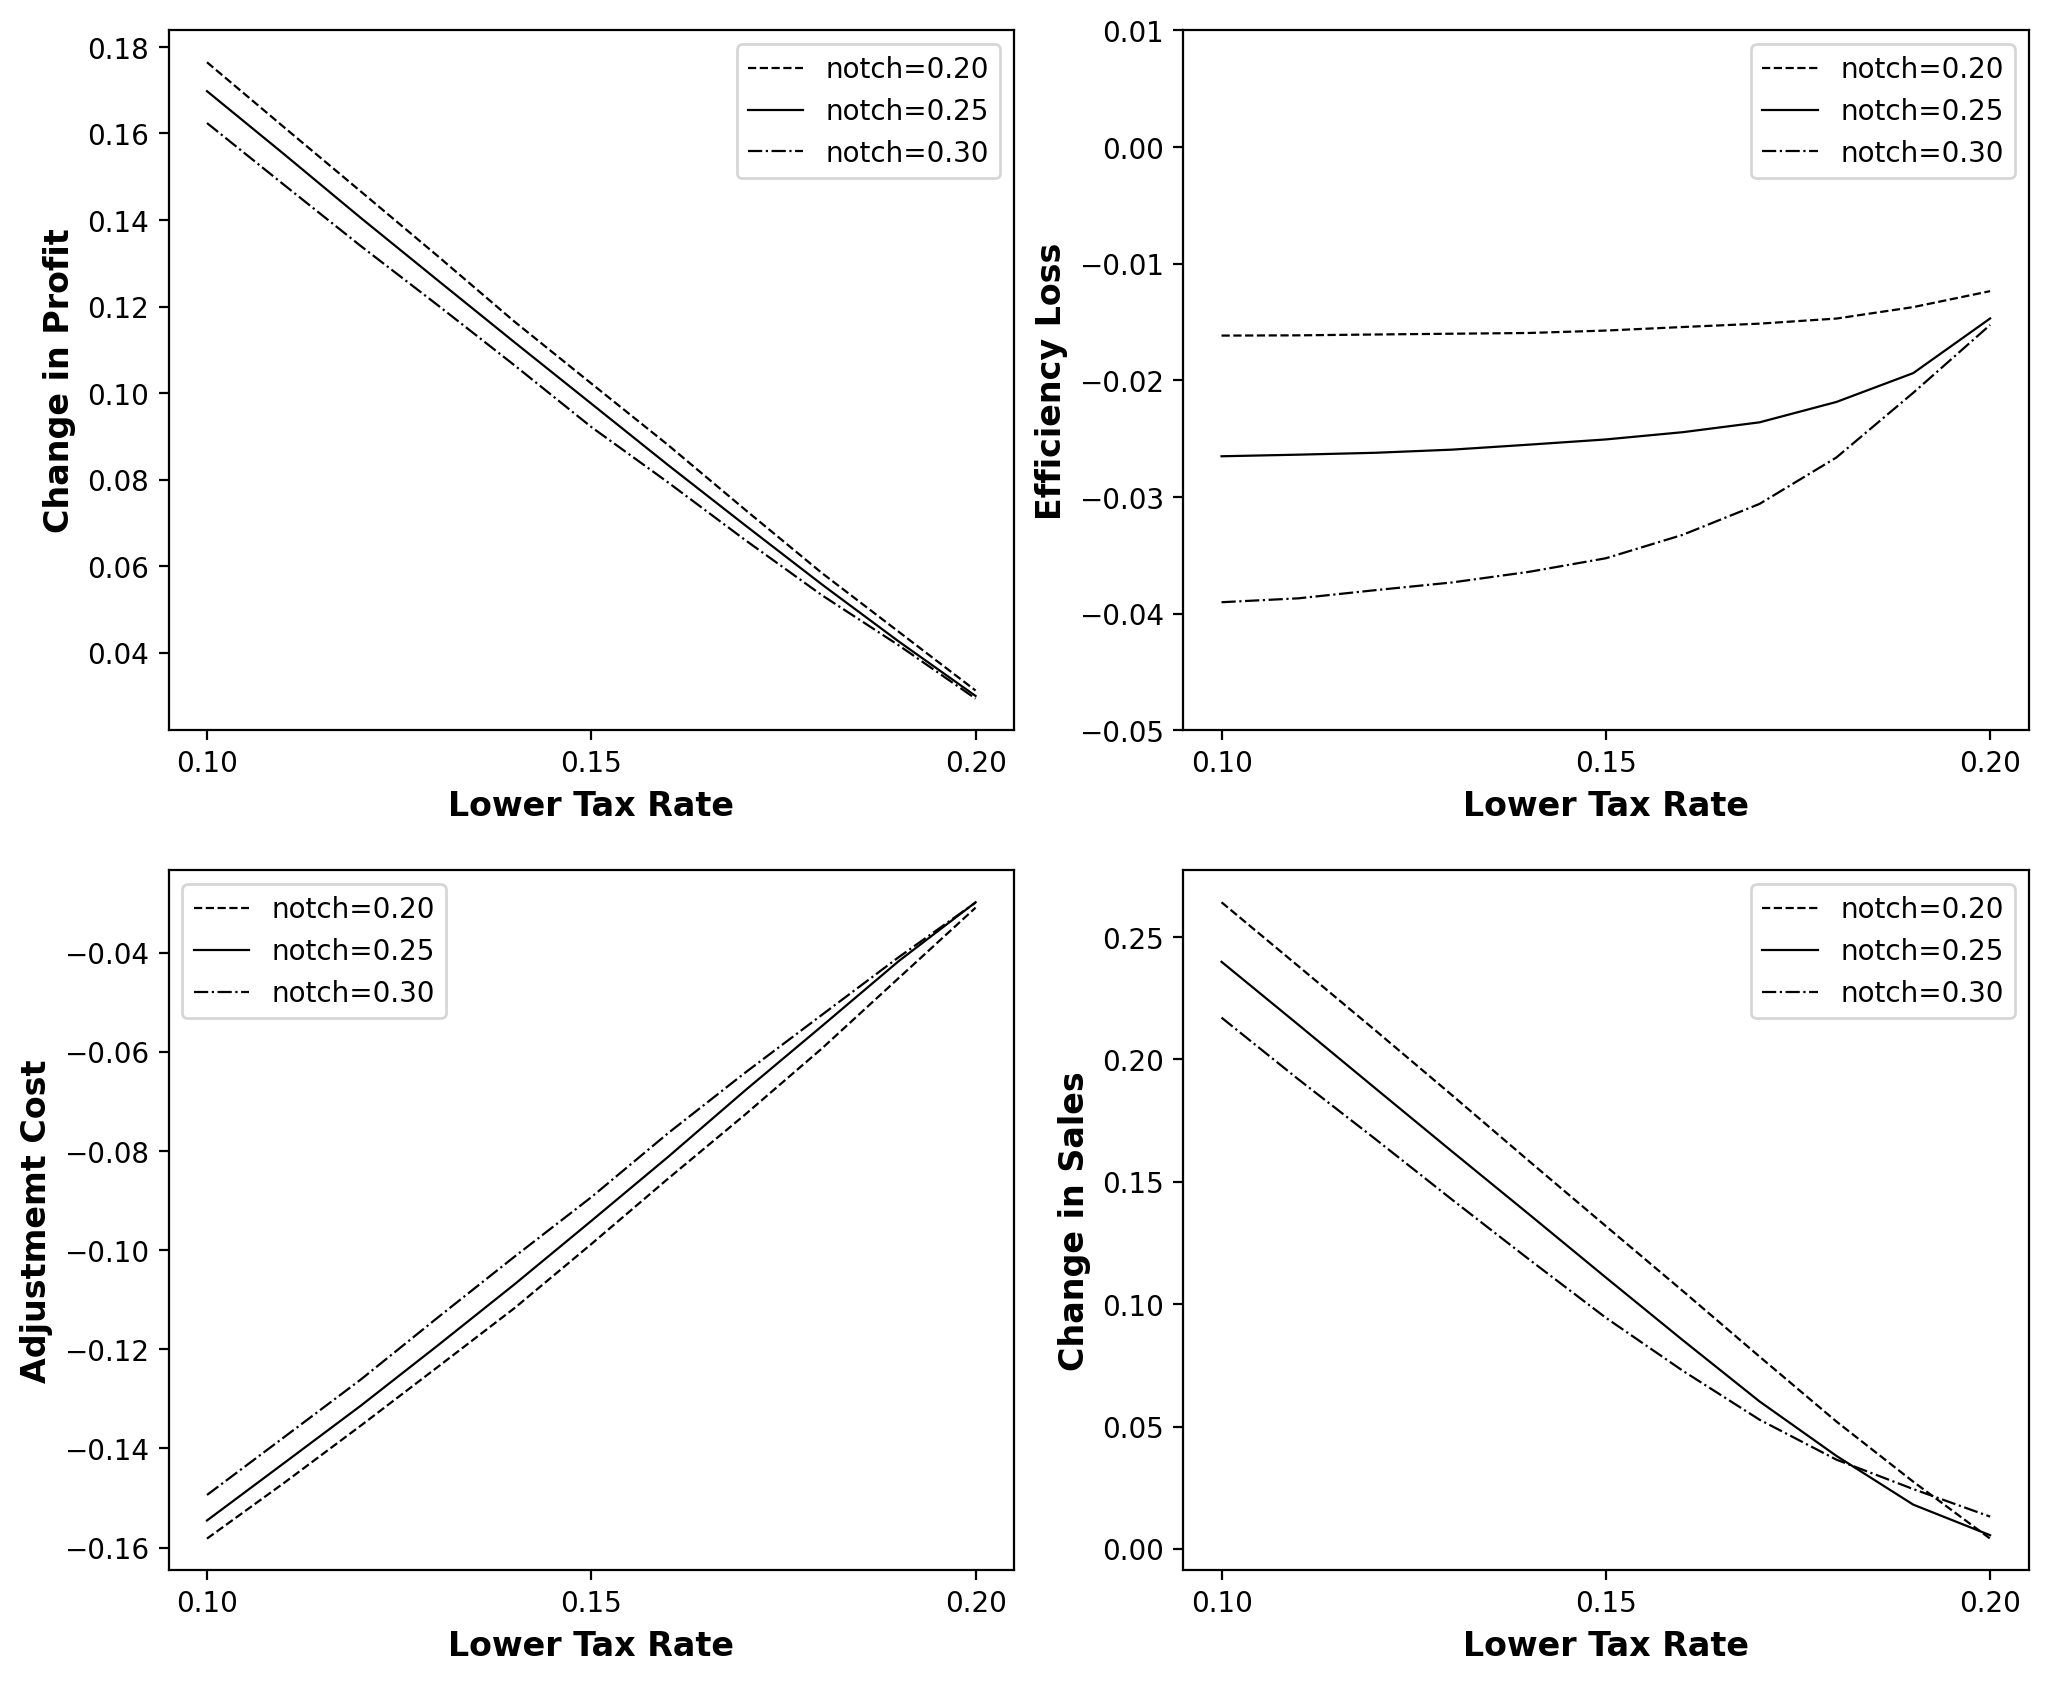

In [109]:

# Take data out from the dictionary.
vary_taxBreakProfit_20 = change_para_rst['0.20'][change_para_rst['0.20']['tau_L']>=10]
#vary_taxBreakProfit_15 = change_para_rst['0.15'][change_para_rst['0.20']['tau_L']>=10]
vary_taxBreakProfit_25 = change_para_rst['0.25'][change_para_rst['0.25']['tau_L']>=10]
vary_taxBreakProfit_30 = change_para_rst['0.30'][change_para_rst['0.30']['tau_L']>=10]
vary_taxBreakProfit_50 = change_para_rst['0.50'][change_para_rst['0.50']['tau_L']>=10]
vary_taxBreakProfit_75 = change_para_rst['0.75'][change_para_rst['0.75']['tau_L']>=10]


# Get all the lower tax levels.
tax_lb_rates        = vary_taxBreakProfit_25['tau_L'].values/100

# Take out the Change in Profit data.
overall_20 = vary_taxBreakProfit_20['Change in Profit'].values
#overall_15 = vary_taxBreakProfit_15['Change in Profit'].values
overall_25 = vary_taxBreakProfit_25['Change in Profit'].values
overall_30 = vary_taxBreakProfit_30['Change in Profit'].values
overall_50 = vary_taxBreakProfit_50['Change in Profit'].values
overall_75 = vary_taxBreakProfit_75['Change in Profit'].values


# Take out the Efficiency without cost data.
EfficiencyWOCost_20 = vary_taxBreakProfit_20['EfficiencyWOCost'].values
#EfficiencyWOCost_15 = vary_taxBreakProfit_15['EfficiencyWOCost'].values
EfficiencyWOCost_25 = vary_taxBreakProfit_25['EfficiencyWOCost'].values
EfficiencyWOCost_30 = vary_taxBreakProfit_30['EfficiencyWOCost'].values
EfficiencyWOCost_50 = vary_taxBreakProfit_50['EfficiencyWOCost'].values
EfficiencyWOCost_75 = vary_taxBreakProfit_75['EfficiencyWOCost'].values


# Take out the Efficiency without cost data.
EfficiencyWCost_20  = vary_taxBreakProfit_20['EfficiencyWCost'].values
#EfficiencyWCost_15  = vary_taxBreakProfit_15['EfficiencyWCost'].values
EfficiencyWCost_25  = vary_taxBreakProfit_25['EfficiencyWCost'].values
EfficiencyWCost_30  = vary_taxBreakProfit_30['EfficiencyWCost'].values
EfficiencyWCost_50  = vary_taxBreakProfit_50['EfficiencyWCost'].values
EfficiencyWCost_75  = vary_taxBreakProfit_75['EfficiencyWCost'].values


# Take out the cost data.
changeSales_20 = vary_taxBreakProfit_20['change_sales'].values
#Cost_15 = vary_taxBreakProfit_15['change_sales'].values
changeSales_25 = vary_taxBreakProfit_25['change_sales'].values
changeSales_30 = vary_taxBreakProfit_30['change_sales'].values
changeSales_50 = vary_taxBreakProfit_50['change_sales'].values
changeSales_75 = vary_taxBreakProfit_75['change_sales'].values


# Visualize the results.
fig_changePara, ((ax1,ax2),(ax3,ax4))  = plt.subplots(2,2, figsize=(12,10), dpi=200)

ax1.plot(tax_lb_rates, overall_20, c='k', linestyle='--', linewidth=0.8, label='notch=0.20')
ax1.plot(tax_lb_rates, overall_25, c='k', linestyle='-', linewidth=0.8, label='notch=0.25')
#ax1.plot(tax_lb_rates, overall_50, c='k', linestyle=':', linewidth=0.8,label='notch=0.50')
ax1.plot(tax_lb_rates, overall_30, c='k', linestyle='-.', linewidth=0.8,label='notch=0.30')
ax1.set(xticks=np.arange(10.0,21.0, step=5)/100)
ax1.set_xlabel('Lower Tax Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Change in Profit', fontsize=12, fontweight='bold')
ax1.legend()

ax2.plot(tax_lb_rates, EfficiencyWOCost_20, c='k', linestyle='--', linewidth=0.8,label='notch=0.20')
ax2.plot(tax_lb_rates, EfficiencyWOCost_25, c='k', linestyle='-', linewidth=0.8, label='notch=0.25')
#ax2.plot(tax_lb_rates, EfficiencyWOCost_50, c='k', linestyle=':', linewidth=0.8,label='notch=0.50')
ax2.plot(tax_lb_rates, EfficiencyWOCost_30, c='k', linestyle='-.', linewidth=0.8,label='notch=0.30')
ax2.set(ylim=[-0.05, 0.01])
ax2.set(xticks=np.arange(10.0,21.0, step=5)/100)
ax2.set_xlabel('Lower Tax Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('Efficiency Loss', fontsize=12, fontweight='bold')
ax2.legend()

ax3.plot(tax_lb_rates, EfficiencyWCost_20, c='k', linestyle='--', linewidth=0.8,label='notch=0.20')
ax3.plot(tax_lb_rates, EfficiencyWCost_25, c='k', linestyle='-', linewidth=0.8, label='notch=0.25')
#ax3.plot(tax_lb_rates, EfficiencyWCost_50, c='k', linestyle=':', linewidth=0.8, label='notch=0.50')
ax3.plot(tax_lb_rates, EfficiencyWCost_30, c='k', linestyle='-.', linewidth=0.8, label='notch=0.30')
ax3.set(xticks=np.arange(10.0,21.0, step=5)/100)
ax3.set_xlabel('Lower Tax Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('Adjustmemt Cost', fontsize=12, fontweight='bold')
ax3.legend()

ax4.plot(tax_lb_rates, changeSales_20, c='k', linestyle='--', linewidth=0.8,label='notch=0.20')
ax4.plot(tax_lb_rates, changeSales_25, c='k', linestyle='-', linewidth=0.8, label='notch=0.25')
#ax4.plot(tax_lb_rates, changeSales_50, c='k', linestyle=':', linewidth=0.8,label='notch=0.50')
ax4.plot(tax_lb_rates, changeSales_30, c='k', linestyle='-.', linewidth=0.8,label='notch=0.30')
ax4.set(xticks=np.arange(10.0,21.0, step=5)/100)
ax4.set_xlabel('Lower Tax Rate', fontsize=12, fontweight='bold')
ax4.set_ylabel('Change in Sales', fontsize=12, fontweight='bold')
ax4.legend()

In [110]:
# Output the graph.
fig_changePara.savefig(figure_path+'bunch_cost_effLossJune172023.pdf')

In [65]:
# Output the results of the change in profit, sales, ineffciency and adjustment cost.
change_para_rst15 = change_para_rst['0.15']
change_para_rst20 = change_para_rst['0.20']
change_para_rst25 = change_para_rst['0.25']
change_para_rst30 = change_para_rst['0.30']
change_para_rst50 = change_para_rst['0.50']
change_para_rst75 = change_para_rst['0.75']

# Compile data together.
change_para_rst_df = pd.concat((change_para_rst15,change_para_rst20))
change_para_rst_df = pd.concat((change_para_rst_df,change_para_rst25))
change_para_rst_df = pd.concat((change_para_rst_df,change_para_rst30))
change_para_rst_df = pd.concat((change_para_rst_df,change_para_rst50))
change_para_rst_df = pd.concat((change_para_rst_df,change_para_rst75))

# Output the data to a .csv file for future use.
change_para_rst_df.to_csv(path+'changePara_profitandcostChangeJune172023.csv', index=False)

### This part works with tax change.

We look at how changes in tax break and tax notch would affect the following outcomes: total tax collected with and without the tax notch; increase of FDI share; size (profit) and productivity of stayers and compliers; inefficiency; cost.

In [14]:
def GetOutcomeChange(theta, mu_c, k, tau_L, notch, Reps):
    # Store the results.
    final_rst = np.zeros((Reps,21))
    # Loop Reps times.
    for Rep in range(1, Reps+1):
        # See the process of drawing these random numbers in 
        # section B.1 Online Appendix of James & Ariell (2015 CJE)
        np.random.seed(1234+Rep)
        copula_u = np.random.uniform(0,1,101310)

        np.random.seed(123+Rep)
        copula_x = np.random.uniform(0,1,101310)

        copula_a = copula_x*(1-copula_x)
        copula_b = theta + copula_a*((theta-1)**2)
        copula_c = 2*copula_a*(copula_u*(theta**2)+1-copula_u) + theta*(1-2*copula_a)
        copula_d = np.sqrt(theta)*np.sqrt(theta + 4*copula_a*copula_u*(1-copula_u)*((1-theta)**2))
        copula_v = (copula_c-(1-2*copula_x)*copula_d)/(2*copula_b)

        # We assume that cost is just a uniform distribution.
        copula_cost = copula_u*mu_c

        # Now we generate varphi based on U we draw.
        # If U is drawn from a uniform distribution [0,1], and T = xm*U**(-1/k), then T is Pareto-Distributed.
        xm = 1

        copula_varphi = xm*((1-copula_v)**(-1/k))

        cost_varphi_df = pd.DataFrame(data={'copula_cost':copula_cost, 'copula_varphi':copula_varphi})

        # Winsorize the sample. Drop the bottom 1% and top 1% sample.
        top99   = np.quantile(copula_varphi, 0.99)
        bottom1 = np.quantile(copula_varphi, 0.01)

        eta_varphi_winsorized = copy.deepcopy(cost_varphi_df[(cost_varphi_df['copula_varphi']<top99)&(cost_varphi_df['copula_varphi']>bottom1)])
        eta_varphi_winsorized.reset_index(drop=True, inplace=True)
        costVarphi_corr = np.corrcoef(eta_varphi_winsorized['copula_cost'], eta_varphi_winsorized['copula_varphi'])[0][1]

        # Compile data into a dataFrame
        sim_firm_df = pd.DataFrame(data={'beta_cf_simul': simul_beta_df['beta_cf_simul'],
                                         'simul_bin_id': simul_beta_df['simul_bin_id'],
                                         'eta_simul': simul_beta_df['eta_simul'],
                                         'cost_simul': eta_varphi_winsorized['copula_cost'][:len(simul_beta_df)],
                                         'varphi_simul': eta_varphi_winsorized['copula_varphi'][:len(simul_beta_df)]})

        # See how many firms might choose to bunch. 
        #total_possible_bunch = len(sim_firm_df[sim_firm_df['beta_cf_simul']<notch])

        # Compile tax rate before bunching. 
        sim_firm_df['tau_noBunch'] = tau_L
        sim_firm_df.loc[sim_firm_df['beta_cf_simul']<notch, ['tau_noBunch']] = tau_H

        #############################################################################################
        # We first calculate the tax collected if there is no tax notch (uniform tax rate=0.225)
        #############################################################################################
        # Outcomes under no tax notch regime.
        p_NN, x_NN, h_NN, m_NN, pi_postTaxNN = get_FirmVar(sim_firm_df['beta_cf_simul'], sim_firm_df['eta_simul'], 
                                                           sigma, w_h, w_m, 
                                                           tau_H,
                                                           sim_firm_df['varphi_simul'], 
                                                           big_p, big_x, 
                                                           1, 0)
        # Calculate pre-tax profit without the tax notch, and take logs.
        pi_PreTaxNN = pi_postTaxNN/(1-0.225)

        # Calculate tax collected.
        sim_firm_df['tax_NN']      = np.log(pi_PreTaxNN*0.225)


        #######################################################################################
        # We then calculate the tax collected if there is tax notch.
        #######################################################################################
        # Outcomes without bunching (NB means no bunching).
        p_NB, x_NB, h_NB, m_NB, pi_postTaxNB = get_FirmVar(sim_firm_df['beta_cf_simul'], sim_firm_df['eta_simul'], 
                                                           sigma, w_h, w_m, 
                                                           sim_firm_df['tau_noBunch'],
                                                           sim_firm_df['varphi_simul'], 
                                                           big_p, big_x, 
                                                           1, 0)

        # Take logs.
        sim_firm_df['p_NB'] = np.log(p_NB)
        sim_firm_df['x_NB'] = np.log(x_NB)
        sim_firm_df['h_NB'] = np.log(h_NB)
        sim_firm_df['m_NB'] = np.log(m_NB)
        sim_firm_df['pi_postTaxNB'] = np.log(pi_postTaxNB)

        # Calculate pre-tax profit.
        sim_firm_df['pi_preTax_NB'] = np.log(pi_postTaxNB/(1-sim_firm_df['tau_noBunch']))

        # Calculate tax without bunching.
        sim_firm_df['tax_NB'] = np.log((pi_postTaxNB/(1-sim_firm_df['tau_noBunch']))*sim_firm_df['tau_noBunch'])

        # cost and scale
        costscale_corr = np.corrcoef(sim_firm_df['x_NB'], sim_firm_df['cost_simul'])[0][1]

        # Now we look at firms bunching decisions. We first calculate the LHS and RHS of 7
        # Calculate the rhs of equation 7 

        part1 = get_delta(sigma, sim_firm_df['eta_simul'], notch)-sim_firm_df['cost_simul']
        part2 = ((1-tau_L)/(1-tau_H))**sigma
        RHS   = part1*part2

        # Calculate the LHS of equation (7). 
        LHS   = get_delta(sigma, sim_firm_df['eta_simul'], sim_firm_df['beta_cf_simul'])
        bunch_decision = (LHS>=RHS).astype(int) # here 0 means it is optimal to bunch, 1 means to stay and not to bunch.

        # compile bunching decision into the dataframe
        sim_firm_df['bunch_decision'] = bunch_decision

        # When sim_firm_df['beta_cf_simul']>=0.25, there is no bunching.
        sim_firm_df.loc[sim_firm_df['beta_cf_simul']>=notch, ['bunch_decision']]=1

        # When sim_firm_df['beta_cf_simul']<=0.07, there is no bunching.
        #sim_firm_df.loc[sim_firm_df['beta_cf_simul']<=0.07, ['bunch_decision']]=1

        # Let's create a column of firms' final beta: when there is no bunching, final_beta = beta_cf_simul;
        # When ther is bunching, final_beta = 0.25.
        sim_firm_df['final_beta'] = sim_firm_df['beta_cf_simul']
        sim_firm_df.loc[sim_firm_df['bunch_decision']== 0, ['final_beta']] = notch

        # Calculate final_bin_ID.
        # Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
        sim_firm_df['final_bin_id'] = np.digitize(sim_firm_df['final_beta'], bins_temp, right=False)
        sim_firm_df['final_bin_id'] = sim_firm_df['final_bin_id'] +1

        # Note that eta does not change, so final_eta = eta_simul
        sim_firm_df['final_eta'] = sim_firm_df['eta_simul']

        # Final Tax rate.
        sim_firm_df['final_tau'] = tau_H
        sim_firm_df.loc[sim_firm_df['final_beta']>=notch, ['final_tau']]= tau_L

        # Outcomes with bunching.
        final_p, final_x, final_h, final_m, pi_PostTax = get_FirmVar(sim_firm_df['final_beta'], sim_firm_df['final_eta'], 
                                                                     sigma, w_h, w_m, 
                                                                     sim_firm_df['final_tau'],
                                                                     sim_firm_df['varphi_simul'], 
                                                                     big_p, big_x, 
                                                                     sim_firm_df['bunch_decision'], 
                                                                     sim_firm_df['cost_simul'])

        # Compile things. 
        sim_firm_df['final_p']          = np.log(final_p)
        sim_firm_df['final_x']          = np.log(final_x)
        sim_firm_df['final_h']          = np.log(final_h)
        sim_firm_df['final_m']          = np.log(final_m)
        sim_firm_df['final_pi_PostTax'] = np.log(pi_PostTax)
        sim_firm_df['final_pi_PreTax']  = np.log(pi_PostTax/(1-sim_firm_df['final_tau']))

        # We calculate the tax collected after bunching.
        sim_firm_df['final_tax'] =  np.log((pi_PostTax/(1-sim_firm_df['final_tau']))*sim_firm_df['final_tau'])

        #######################################################################################
        # Summarize the change in tax collected.
        #######################################################################################
        # Calculate the total tax collected if there is no tax notch.
        total_tax_NN    = np.sum(math.e**(np.array(sim_firm_df['tax_NN'])))

        # Calculate the total tax collected before firms choose to bunch.
        total_tax_NB    = np.sum(math.e**(np.array(sim_firm_df['tax_NB'])))

        # Calculate the total tax collected after firms choose to bunch.
        # Note that compared to total_tax_NB, the difference only comes from those firms that choose to bunch.
        total_tax_final = np.sum(math.e**(np.array(sim_firm_df['final_tax'])))
        
        ##########################################################################################
        # Look at the characteristics of firms that choose to bunch and firms that choose to stay.
        ##########################################################################################
        mean_stayer_varphi  = np.mean(sim_firm_df[(sim_firm_df['bunch_decision']==1)&(sim_firm_df['beta_cf_simul']<notch)]['varphi_simul'])
        mean_buncher_varphi = np.mean(sim_firm_df[(sim_firm_df['bunch_decision']==0)&(sim_firm_df['beta_cf_simul']<notch)]['varphi_simul'])

        mean_stayer_piPostTaxNB  = np.mean(math.e**(sim_firm_df[(sim_firm_df['bunch_decision']==1)&(sim_firm_df['beta_cf_simul']<notch)]['pi_postTaxNB']))
        mean_buncher_piPostTaxNB = np.mean(math.e**(sim_firm_df[(sim_firm_df['bunch_decision']==0)&(sim_firm_df['beta_cf_simul']<notch)]['pi_postTaxNB']))
       
        mean_stayer_piPreTaxNB  = np.mean(math.e**(sim_firm_df[(sim_firm_df['bunch_decision']==1)&(sim_firm_df['beta_cf_simul']<notch)]['pi_preTax_NB']))
        mean_buncher_piPreTaxNB = np.mean(math.e**(sim_firm_df[(sim_firm_df['bunch_decision']==0)&(sim_firm_df['beta_cf_simul']<notch)]['pi_preTax_NB']))
       
        #######################################################################################
        # Decompose the change in outcomes.
        #######################################################################################

        # Now we take out the firms that choose to bunch.
        bunched_firms = copy.deepcopy(sim_firm_df[sim_firm_df['bunch_decision']==0])

        # Calculate the change in profit.
        # Overall change in profit.
        change_profit = np.mean(bunched_firms['final_pi_PostTax'] - bunched_firms['pi_postTaxNB'])

        # Calculate the delta(beta*) - delta(\underlined_{\beta}) (efficiency loss for profits)
        # First, without adjustment cost.
        effLoss_profit_noCost = np.mean(np.log(get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])/
                                               get_delta(sigma, bunched_firms['eta_simul'], bunched_firms['beta_cf_simul'])))

        # With adjustment cost.
        effLoss_profit_Cost = np.mean(np.log((get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])
                                             -bunched_firms['cost_simul'])/
                                             get_delta(sigma, bunched_firms['final_eta'], bunched_firms['final_beta'])))

        # Gain in profit because of benefit.
        gain_profit = sigma*(np.log(1-tau_L) - np.log(1-tau_H))

        #######################################################################################
        ### Calculate the increase in Beta and stayer_mmt.
        #######################################################################################
        notch_bin = int(notch*100)
        minBin    = 1
        
        # Calculate the counterfactual distribution of firms (corresponding to h in the bunching estimation).
        temp_h      = sim_firm_df.groupby('simul_bin_id')['beta_cf_simul'].count().reset_index()
        temp_h['h'] = temp_h['beta_cf_simul']/np.sum(temp_h['beta_cf_simul'])

        # Calculate the 'observed' distribution of firms (corresponding to C in the bunching estimation).
        # Note that here, the 'observed' distribution is the distribution of firms with bunching.
        # Note that now since in some bins, all firms are bunched, we need to assign 0 to those bins
        temp_C_all = pd.DataFrame({'final_bin_id':np.arange(2,100)})
        temp_C      = sim_firm_df.groupby('final_bin_id')['beta_cf_simul'].count().reset_index()
        all_C_sim = temp_C_all.merge(temp_C, on='final_bin_id', how='left')
        all_C_sim.fillna(0, inplace=True)
        all_C_sim['C'] = all_C_sim['beta_cf_simul']/np.sum(all_C_sim['beta_cf_simul'])
        
        # Theoretically, all firms should have bunched to the right. However due to firction cost, 
        # some firms still stay to the left. Here we calculate the ratio of real stayers over conterfactual stayers. 
        # The higher the ratio, the higher the frition cost 
        stayer_ratio = np.sum(all_C_sim[all_C_sim['final_bin_id']<notch_bin]['C'])/np.sum(temp_h[temp_h['simul_bin_id']<notch_bin]['h'])

        # b_Bstat: the upper bound of bins of the range (minD, notch].
        b_Bstat = np.arange(minBin+1, notch_bin+1)/100+0.01

        # c_Bstat: conditional probability of "observed" firm distribution
        c_Bstat = np.array(all_C_sim[all_C_sim['final_bin_id']<= notch_bin]['C'])/np.sum(all_C_sim[all_C_sim['final_bin_id']<= notch_bin]['C'])

        # hh: conditional probability of "counter-factual" firm distribution
        hh = np.array(temp_h[temp_h['simul_bin_id']<= notch_bin]['h'])/np.sum(temp_h[temp_h['simul_bin_id']<= notch_bin]['h'])

        # Calculate Dd
        beta_increase = np.sum(b_Bstat*(c_Bstat - hh))/np.sum(b_Bstat*hh)

        
        #######################################################################################
        # Calculate the tax collected from the bunched firms.
        #######################################################################################
        tax_NN_bunchedFirms = np.sum(math.e**(np.array(bunched_firms['tax_NN'])))       # Tax if there is not tax notch.
        tax_NB_bunchedFirms = np.sum(math.e**(np.array(bunched_firms['tax_NB'])))       # Tax before firms choose to bunch.
        tax_B_bunchedFirms  = np.sum(math.e**(np.array(bunched_firms['final_tax'])))    # Tax after firms choose to bunch.

        # We take out the firms that are below the notch at the beginning.
        belowNotch_firms = copy.deepcopy(sim_firm_df[sim_firm_df['beta_cf_simul']<notch])

        # Calculate the tax collected from the bunched firms.
        tax_NN_belowNotch = np.sum(math.e**(np.array(belowNotch_firms['tax_NN'])))       # Tax if there is not tax notch.
        tax_NB_belowNotch = np.sum(math.e**(np.array(belowNotch_firms['tax_NB'])))       # Tax before firms choose to bunch.
        tax_B_belowNotch  = np.sum(math.e**(np.array(belowNotch_firms['final_tax'])))    # Tax after firms choose to bunch.

        rst = [beta_increase, stayer_ratio, 
               change_profit, effLoss_profit_noCost, effLoss_profit_Cost, gain_profit,
               total_tax_NN, total_tax_NB, total_tax_final, 
               tax_NN_belowNotch, tax_NB_belowNotch, tax_B_belowNotch, 
               tax_NN_bunchedFirms, tax_NB_bunchedFirms, tax_B_bunchedFirms,
               mean_stayer_varphi, mean_buncher_varphi, 
               # mean_stayer_piPostTaxNB, mean_buncher_piPostTaxNB,
               mean_stayer_piPreTaxNB, mean_buncher_piPreTaxNB,
               notch, tau_L]
        
        final_rst[Rep-1,:] = np.array(rst)
        
        if Rep%50 == 0:
            print(notch, tau_L, Rep)
    
    return final_rst.mean(0)


In [15]:
start_time2 = datetime.now()

Reps  = 100
notch_lst = [0.15, 0.20, 0.25, 0.30, 0.50, 0.75]

# Store results.
ChangePara_rst = []

# Loop over each notch.
for n in notch_lst:
    notch = n
    # Loop over each lower-tax rate.
    for item in range(5, 21):
        tau_L    = item/100
        rst_temp = GetOutcomeChange(theta, mu_c, k, tau_L, notch, Reps)
        
        # Store the result in the final result matrix.
        ChangePara_rst.append(list(rst_temp))

# Keep track of time.
end_time2 = datetime.now()
print('Duration: {}'.format(end_time2 - start_time2))


0.15 0.05 50
0.15 0.05 100
0.15 0.06 50
0.15 0.06 100
0.15 0.07 50
0.15 0.07 100
0.15 0.08 50
0.15 0.08 100
0.15 0.09 50
0.15 0.09 100
0.15 0.1 50
0.15 0.1 100
0.15 0.11 50
0.15 0.11 100
0.15 0.12 50
0.15 0.12 100
0.15 0.13 50
0.15 0.13 100
0.15 0.14 50
0.15 0.14 100
0.15 0.15 50
0.15 0.15 100
0.15 0.16 50
0.15 0.16 100
0.15 0.17 50
0.15 0.17 100
0.15 0.18 50
0.15 0.18 100
0.15 0.19 50
0.15 0.19 100
0.15 0.2 50
0.15 0.2 100
0.2 0.05 50
0.2 0.05 100
0.2 0.06 50
0.2 0.06 100
0.2 0.07 50
0.2 0.07 100
0.2 0.08 50
0.2 0.08 100
0.2 0.09 50
0.2 0.09 100
0.2 0.1 50
0.2 0.1 100
0.2 0.11 50
0.2 0.11 100
0.2 0.12 50
0.2 0.12 100
0.2 0.13 50
0.2 0.13 100
0.2 0.14 50
0.2 0.14 100
0.2 0.15 50
0.2 0.15 100
0.2 0.16 50
0.2 0.16 100
0.2 0.17 50
0.2 0.17 100
0.2 0.18 50
0.2 0.18 100
0.2 0.19 50
0.2 0.19 100
0.2 0.2 50
0.2 0.2 100
0.25 0.05 50
0.25 0.05 100
0.25 0.06 50
0.25 0.06 100
0.25 0.07 50
0.25 0.07 100
0.25 0.08 50
0.25 0.08 100
0.25 0.09 50
0.25 0.09 100
0.25 0.1 50
0.25 0.1 100
0.25 0.11 50
0.2

In [16]:
colum_names = ['betaChange_m', 'stayer_ratio', 
               'change_profit', 'effLoss_profit_noCost', 'effLoss_profit_Cost', 'gain_profit',
               'total_tax_NN', 'total_tax_NB', 'total_tax_final', 
               'tax_NN_belowNotch', 'tax_NB_belowNotch', 'tax_B_belowNotch', 
               'tax_NN_bunchedFirms', 'tax_NB_bunchedFirms', 'tax_B_bunchedFirms',
               'mean_stayer_varphi', 'mean_buncher_varphi', 
               #'mean_stayer_piPostTaxNB', 'mean_buncher_piPostTaxNB',
               'mean_stayer_piPreTaxNB', 'mean_buncher_piPreTaxNB', 
               'notch', 'tau_L']

# Compile data into a dataframe.
ChangePara_df = pd.DataFrame(data=np.array(ChangePara_rst), columns=colum_names)
ChangePara_df['notch'] = ChangePara_df['notch'].astype(np.float32)
ChangePara_df['tau_L'] = ChangePara_df['tau_L'].astype(np.float32)
ChangePara_df

,betaChange_m,stayer_ratio,change_profit,effLoss_profit_noCost,effLoss_profit_Cost,gain_profit,total_tax_NN,total_tax_NB,total_tax_final,tax_NN_belowNotch,...,tax_B_belowNotch,tax_NN_bunchedFirms,tax_NB_bunchedFirms,tax_B_bunchedFirms,mean_stayer_varphi,mean_buncher_varphi,mean_stayer_piPreTaxNB,mean_buncher_piPreTaxNB,notch,tau_L
0,0.422974,0.000000,0.270927,-0.008386,-0.198363,0.477676,3110.277618,1285.749173,873.846406,532.195251,...,120.292484,532.195251,532.195251,120.292484,NaN,1.731859,NaN,0.249637,0.15,0.05
1,0.422971,0.000030,0.246107,-0.008386,-0.198355,0.452848,3110.277618,1423.669827,1033.824005,532.195251,...,142.349430,532.143752,532.143752,142.297931,NaN,1.731766,NaN,0.249620,0.15,0.06
2,0.419569,0.013782,0.224197,-0.008453,-0.195105,0.427756,3110.277618,1557.381954,1202.690477,532.195251,...,177.503774,513.543851,513.543851,158.852374,3.711242,1.704187,0.634635,0.244254,0.15,0.07
3,0.400022,0.059433,0.209088,-0.008448,-0.184856,0.402391,3110.277618,1686.909501,1394.269259,532.195251,...,239.555009,453.938479,453.938479,161.298236,3.456161,1.622891,0.617597,0.226383,0.15,0.08
4,0.378544,0.109258,0.194416,-0.008437,-0.173897,0.376750,3110.277618,1812.276645,1571.560583,532.195251,...,291.479189,402.094573,402.094573,161.378511,3.187419,1.553328,0.558581,0.211746,0.15,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.014863,0.942535,0.075280,-0.039826,-0.073851,0.188957,3110.277618,2962.846034,2943.581564,2399.616277,...,2380.351807,66.053700,66.053700,46.789230,1.766208,1.189565,0.129332,0.060045,0.75,0.16
92,0.010769,0.954843,0.063985,-0.033427,-0.063446,0.160859,3110.277618,2988.477409,2975.699429,2399.616277,...,2386.838297,51.748979,51.748979,38.970998,1.759434,1.175632,0.128448,0.059865,0.75,0.17
93,0.007368,0.966198,0.052319,-0.027646,-0.052456,0.132420,3110.277618,3013.025021,3005.191291,2399.616277,...,2391.782547,38.715075,38.715075,30.881345,1.753047,1.162089,0.127643,0.059833,0.75,0.18
94,0.004533,0.976690,0.040742,-0.021686,-0.041206,0.103633,3110.277618,3036.496252,3032.271111,2399.616277,...,2395.391136,26.807309,26.807309,22.582168,1.747010,1.149057,0.126909,0.060076,0.75,0.19


In [17]:
# Save the data for future use.
ChangePara_df.to_csv(path+'chagePara_TaxBunchingChangeSep152023.csv', index=False)

In [18]:
# Read in the data.
ChangePara_df = pd.read_csv(path+'chagePara_TaxBunchingChangeSep152023.csv')

In [19]:
# Get the total tax collected when there is no tax notch.
total_tax_NN = ChangePara_df['total_tax_NN'][0]

# Let's look at our benchmark case: notch=0.25, tau_L=0.15
# Note that when there is no tax break, the location of the tax notch does not matter.
tax_final_bench = ChangePara_df[(ChangePara_df['notch']==0.25) & (ChangePara_df['tau_L']==0.15)]
tax_final_bench = np.float64(tax_final_bench['total_tax_final'])
tax_final_bench_ratio = tax_final_bench/total_tax_NN
print('Now the tax revenue is {} % lower.'.format(np.around((1-tax_final_bench_ratio)*100,2)))

Now the tax revenue is 19.36 % lower.


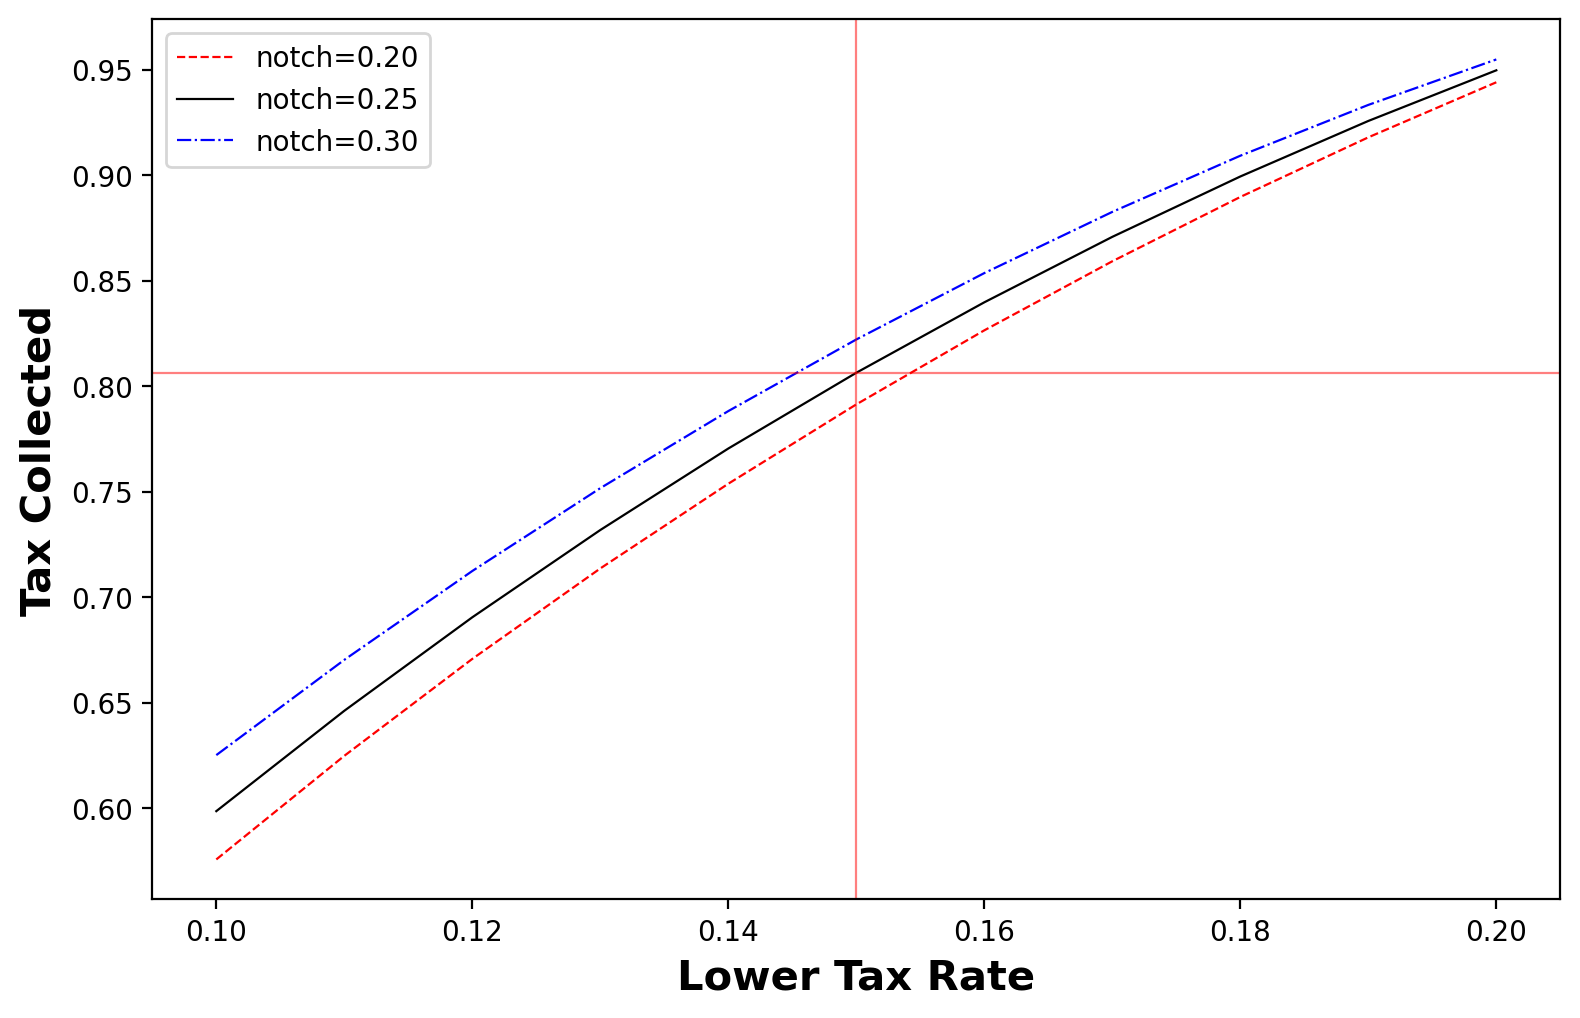

In [20]:
# Let's see how much tax we are paying for the regime.
fig_tax, ax1 = plt.subplots(1,1, figsize=(8,5), dpi=200)
tax_lb_rates = np.arange(10,21)/100

notch20_total_tax_NN = np.array(ChangePara_df[ChangePara_df['notch']==0.20]['total_tax_NN'])[0]
notch25_total_tax_NN = np.array(ChangePara_df[ChangePara_df['notch']==0.25]['total_tax_NN'])[0]
notch30_total_tax_NN = np.array(ChangePara_df[ChangePara_df['notch']==0.30]['total_tax_NN'])[0]

# Get the final tax collected with the notch.
notch20_total_tax_final = ChangePara_df[(ChangePara_df['notch']==0.20)&(ChangePara_df['tau_L']>=0.10)]['total_tax_final']
notch25_total_tax_final = ChangePara_df[(ChangePara_df['notch']==0.25)&(ChangePara_df['tau_L']>=0.10)]['total_tax_final']
notch30_total_tax_final = ChangePara_df[(ChangePara_df['notch']==0.30)&(ChangePara_df['tau_L']>=0.10)]['total_tax_final']

# Calculate the ratio.
notch20ratio = notch20_total_tax_final/total_tax_NN
notch25ratio = notch25_total_tax_final/total_tax_NN
notch30ratio = notch30_total_tax_final/total_tax_NN

ax1.plot(tax_lb_rates, notch20ratio, c='r', linestyle='dashed', linewidth=0.8, label='notch=0.20')
ax1.plot(tax_lb_rates, notch25ratio, c='k', linestyle='solid', linewidth=0.8, label='notch=0.25')
ax1.plot(tax_lb_rates, notch30ratio, c='b', linestyle='dashdot', linewidth=0.8, label='notch=0.30')
#ax1.set(ylim=[0.05, 0.15])
ax1.axvline(x=0.15, c='r', linewidth=0.8, alpha=0.5)
ax1.axhline(y=tax_final_bench_ratio, c='r', linewidth=0.8, alpha=0.5)
#ax.set(xlabel='Lower Tax Rate', ylabel='Tax Collected')
ax1.legend()
#ax1.set_xlabel('Lower Tax Rate', fontweight='bold')
ax1.set_xlabel('Lower Tax Rate',fontsize=15.0, fontweight='bold')
ax1.set_ylabel('Tax Collected', fontsize=15.0, fontweight='bold')

plt.subplots_adjust(left=0.1, right=0.98, top=0.98, bottom=0.1) 

In [21]:
# Save the figure.
fig_tax.savefig(figure_path+'tax_costJune172023color.pdf')

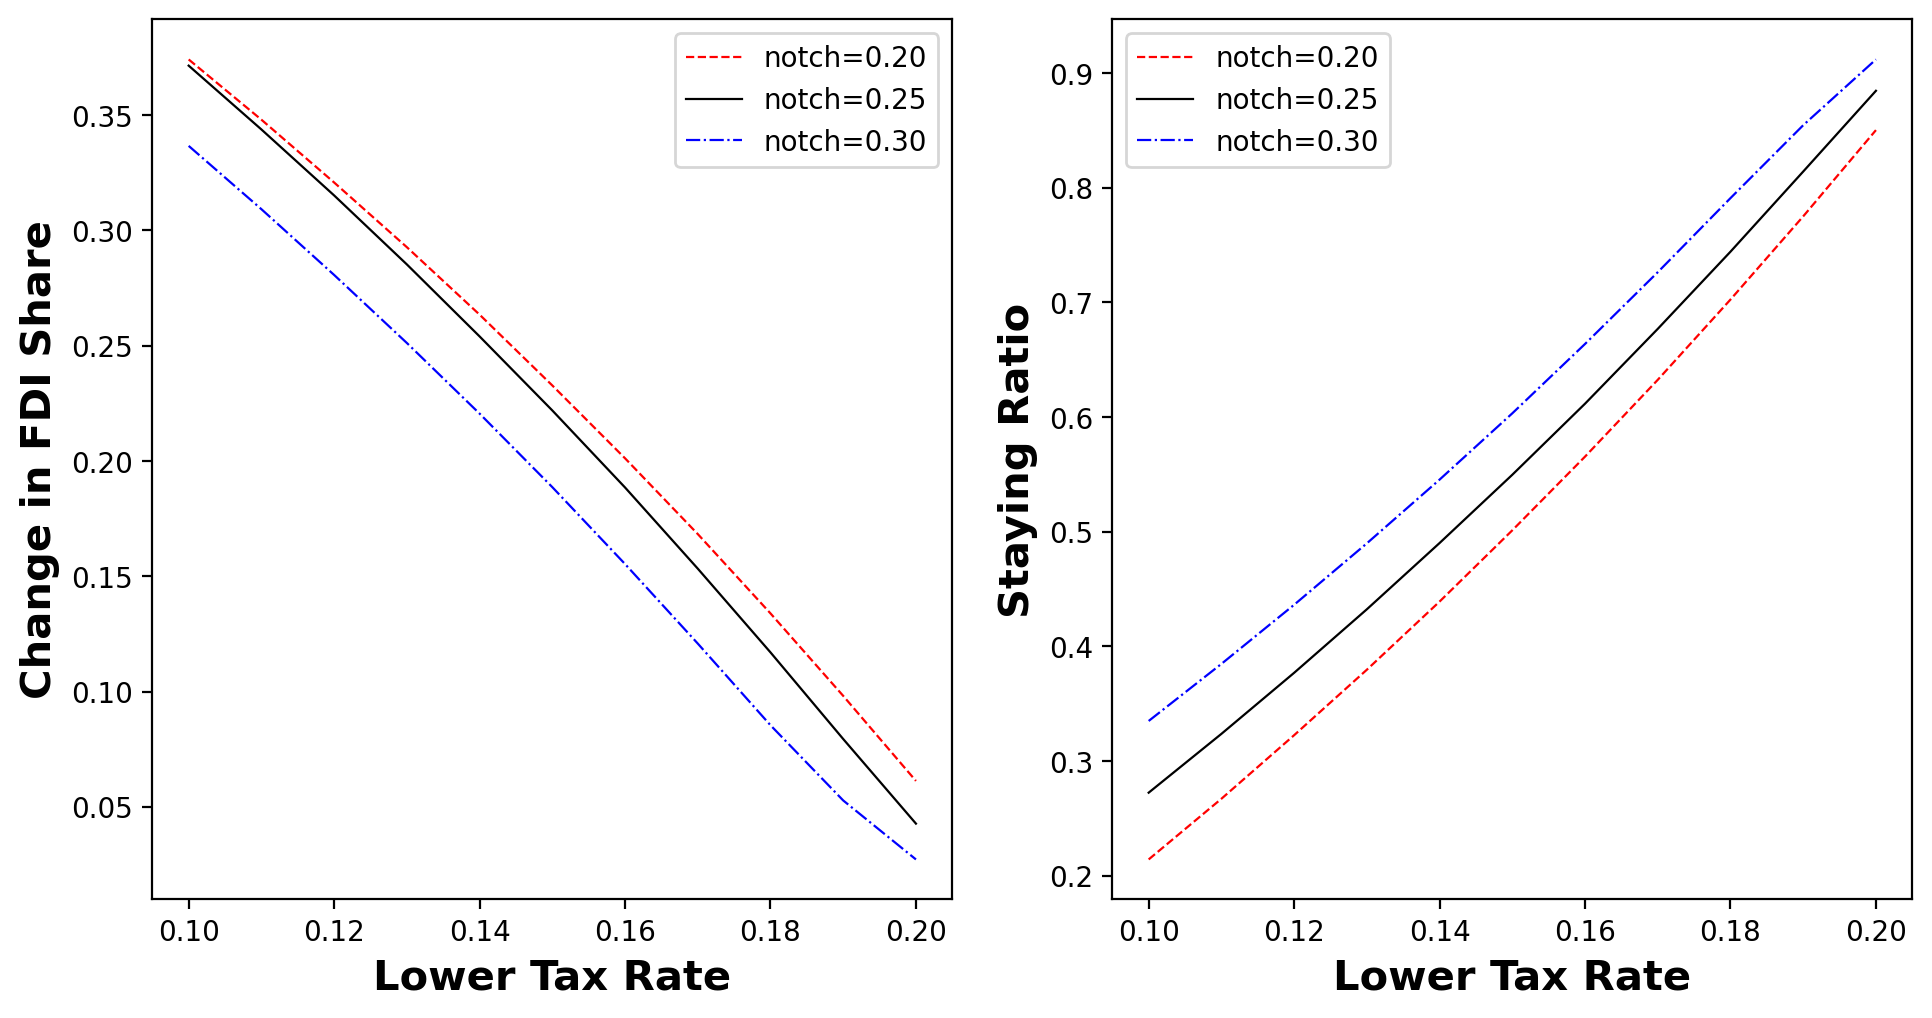

In [22]:
# Let's see how the bunching behavior is like. 
tax_lb_rates = np.arange(10,21)/100

notch20_betaChange = ChangePara_df[(ChangePara_df['notch']==0.20)&(ChangePara_df['tau_L']>=0.10)]['betaChange_m']
notch25_betaChange = ChangePara_df[(ChangePara_df['notch']==0.25)&(ChangePara_df['tau_L']>=0.10)]['betaChange_m']
notch30_betaChange = ChangePara_df[(ChangePara_df['notch']==0.30)&(ChangePara_df['tau_L']>=0.10)]['betaChange_m']

notch20_stayer_ratio = ChangePara_df[(ChangePara_df['notch']==0.20)&(ChangePara_df['tau_L']>=0.10)]['stayer_ratio']
notch25_stayer_ratio = ChangePara_df[(ChangePara_df['notch']==0.25)&(ChangePara_df['tau_L']>=0.10)]['stayer_ratio']
notch30_stayer_ratio = ChangePara_df[(ChangePara_df['notch']==0.30)&(ChangePara_df['tau_L']>=0.10)]['stayer_ratio']

figBunching, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5), dpi=200)
ax1.plot(tax_lb_rates, notch20_betaChange, c='r', linestyle='dashed', linewidth=0.8, label='notch=0.20')
ax1.plot(tax_lb_rates, notch25_betaChange, c='k', linestyle='solid', linewidth=0.8, label='notch=0.25')
ax1.plot(tax_lb_rates, notch30_betaChange, c='b', linestyle='dashdot', linewidth=0.8, label='notch=0.30')
#ax1.set(xlabel='Lower Tax Rate', ylabel='Change in FDI Share')
ax1.set_xlabel('Lower Tax Rate', fontsize=15.0, fontweight='bold')
ax1.set_ylabel('Change in FDI Share', fontsize=15.0, fontweight='bold')
#ax1.set(ylim=[0.05, 0.15])
ax1.legend()

ax2.plot(tax_lb_rates, notch20_stayer_ratio, c='r', linestyle='dashed', linewidth=0.8, label='notch=0.20')
ax2.plot(tax_lb_rates, notch25_stayer_ratio, c='k', linestyle='solid', linewidth=0.8, label='notch=0.25')
ax2.plot(tax_lb_rates, notch30_stayer_ratio, c='b', linestyle='dashdot', linewidth=0.8, label='notch=0.30')
ax2.set_xlabel('Lower Tax Rate', fontsize=15.0, fontweight='bold')
ax2.set_ylabel('Staying Ratio', fontsize=15.0, fontweight='bold')
#ax1.set(ylim=[0.05, 0.15])
ax2.legend()

plt.subplots_adjust(left=0.1, right=0.98, top=0.98, bottom=0.1) 

In [23]:
# Save the figures.
figBunching.savefig(figure_path+'change_in_bunchingJune172023color.pdf')

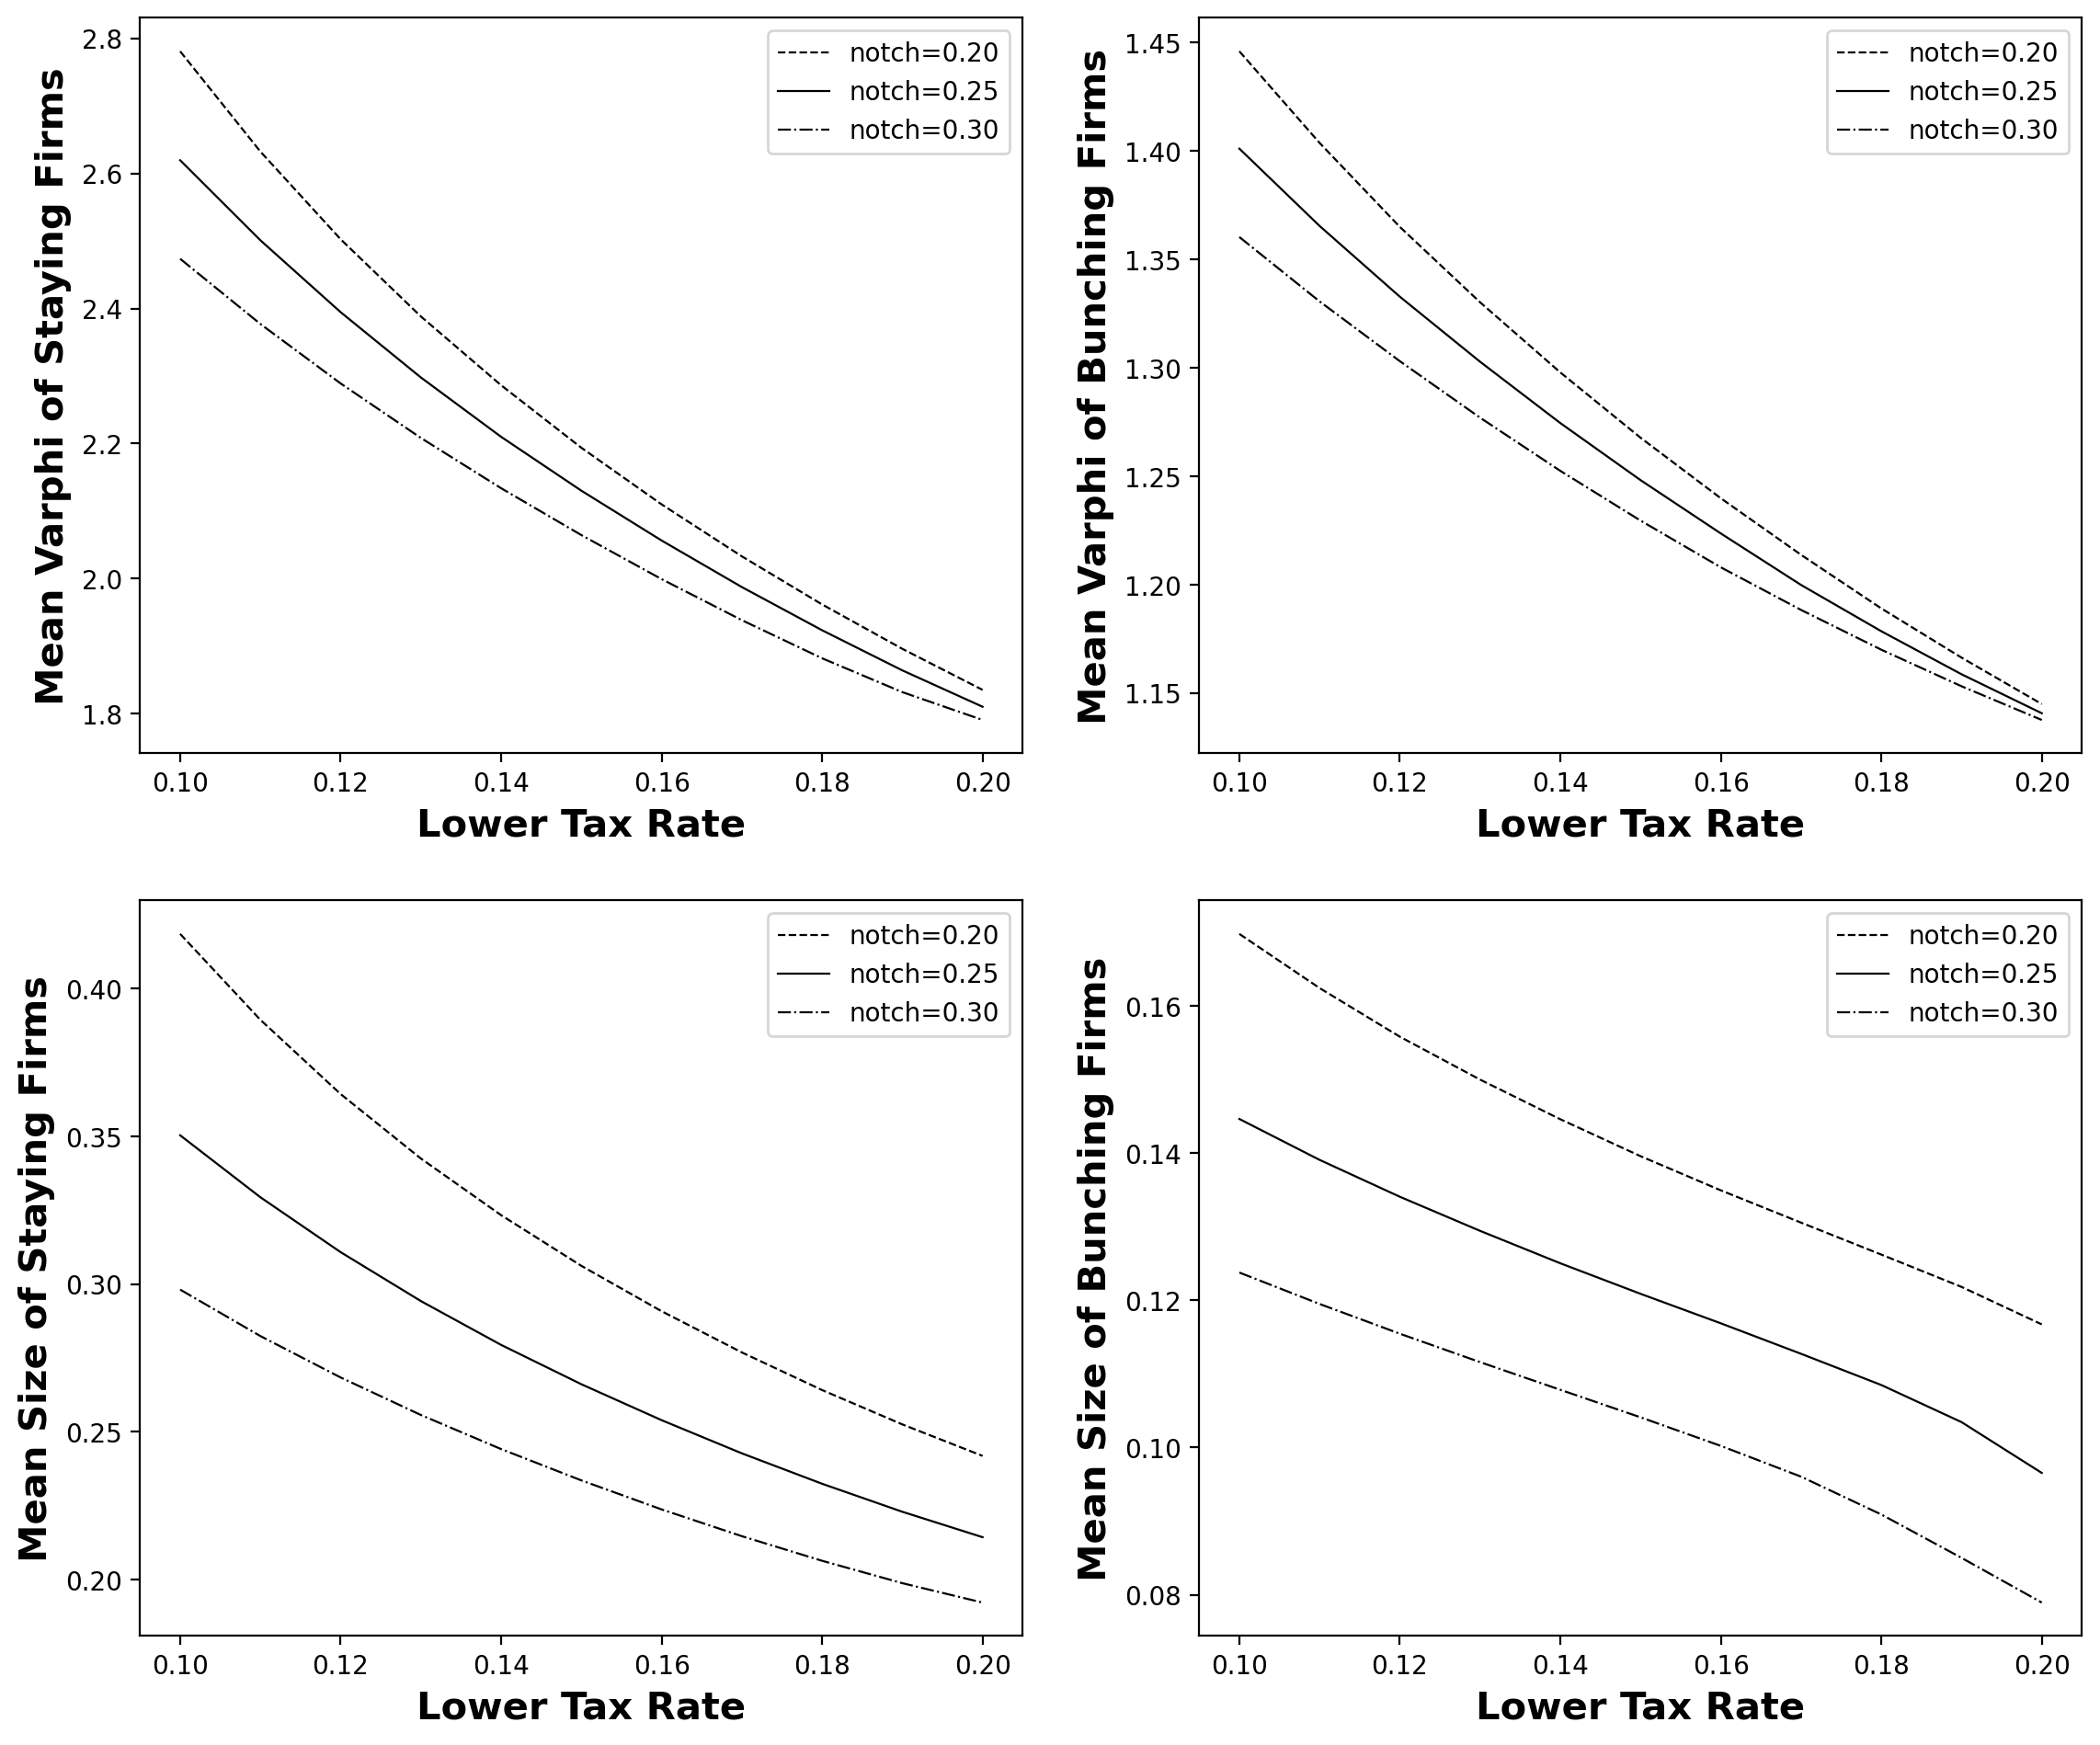

In [27]:
# Let's see how the bunching behavior is like. 
tax_lb_rates = np.arange(10,21)/100

notch20_varphi_stay  = ChangePara_df[(ChangePara_df['notch']==0.20)&(ChangePara_df['tau_L']>=0.10)]['mean_stayer_varphi']
notch25_varphi_stay  = ChangePara_df[(ChangePara_df['notch']==0.25)&(ChangePara_df['tau_L']>=0.10)]['mean_stayer_varphi']
notch30_varphi_stay  = ChangePara_df[(ChangePara_df['notch']==0.30)&(ChangePara_df['tau_L']>=0.10)]['mean_stayer_varphi']

notch20_varphi_bunch = ChangePara_df[(ChangePara_df['notch']==0.20)&(ChangePara_df['tau_L']>=0.10)]['mean_buncher_varphi']
notch25_varphi_bunch = ChangePara_df[(ChangePara_df['notch']==0.25)&(ChangePara_df['tau_L']>=0.10)]['mean_buncher_varphi']
notch30_varphi_bunch = ChangePara_df[(ChangePara_df['notch']==0.30)&(ChangePara_df['tau_L']>=0.10)]['mean_buncher_varphi']

#notch20_size_stay  = ChangePara_df[ChangePara_df['notch']==0.20]['mean_stayer_piPostTaxNB']
#notch25_size_stay  = ChangePara_df[ChangePara_df['notch']==0.25]['mean_stayer_piPostTaxNB']
#notch30_size_stay  = ChangePara_df[ChangePara_df['notch']==0.30]['mean_stayer_piPostTaxNB']

#notch20_size_bunch  = ChangePara_df[ChangePara_df['notch']==0.20]['mean_buncher_piPostTaxNB']
#notch25_size_bunch  = ChangePara_df[ChangePara_df['notch']==0.25]['mean_buncher_piPostTaxNB']
#notch30_size_bunch  = ChangePara_df[ChangePara_df['notch']==0.30]['mean_buncher_piPostTaxNB']

notch20_size_stay  = ChangePara_df[(ChangePara_df['notch']==0.20)&(ChangePara_df['tau_L']>=0.10)]['mean_stayer_piPreTaxNB']
notch25_size_stay  = ChangePara_df[(ChangePara_df['notch']==0.25)&(ChangePara_df['tau_L']>=0.10)]['mean_stayer_piPreTaxNB']
notch30_size_stay  = ChangePara_df[(ChangePara_df['notch']==0.30)&(ChangePara_df['tau_L']>=0.10)]['mean_stayer_piPreTaxNB']

notch20_size_bunch  = ChangePara_df[(ChangePara_df['notch']==0.20)&(ChangePara_df['tau_L']>=0.10)]['mean_buncher_piPreTaxNB']
notch25_size_bunch  = ChangePara_df[(ChangePara_df['notch']==0.25)&(ChangePara_df['tau_L']>=0.10)]['mean_buncher_piPreTaxNB']
notch30_size_bunch  = ChangePara_df[(ChangePara_df['notch']==0.30)&(ChangePara_df['tau_L']>=0.10)]['mean_buncher_piPreTaxNB']


fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,10), dpi=200)
ax1.plot(tax_lb_rates, notch20_varphi_stay, c='k', linestyle='dashed', linewidth=0.8, label='notch=0.20')
ax1.plot(tax_lb_rates, notch25_varphi_stay, c='k', linestyle='solid', linewidth=0.8, label='notch=0.25')
ax1.plot(tax_lb_rates, notch30_varphi_stay, c='k', linestyle='dashdot', linewidth=0.8, label='notch=0.30')
#ax1.set(ylim=[0.05, 0.15])
ax1.legend()
ax1.set_xlabel('Lower Tax Rate', fontsize=15, fontweight='bold')
ax1.set_ylabel('Mean Varphi of Staying Firms', fontsize=15, fontweight='bold')


ax2.plot(tax_lb_rates, notch20_varphi_bunch, c='k', linestyle='dashed', linewidth=0.8, label='notch=0.20')
ax2.plot(tax_lb_rates, notch25_varphi_bunch, c='k', linestyle='solid', linewidth=0.8, label='notch=0.25')
ax2.plot(tax_lb_rates, notch30_varphi_bunch, c='k', linestyle='dashdot', linewidth=0.8, label='notch=0.30')
#ax1.set(ylim=[0.05, 0.15])
ax2.legend()
ax2.set_xlabel('Lower Tax Rate', fontsize=15, fontweight='bold')
ax2.set_ylabel('Mean Varphi of Bunching Firms', fontsize=15, fontweight='bold')

ax3.plot(tax_lb_rates, notch20_size_stay, c='k', linestyle='dashed', linewidth=0.8, label='notch=0.20')
ax3.plot(tax_lb_rates, notch25_size_stay, c='k', linestyle='solid', linewidth=0.8, label='notch=0.25')
ax3.plot(tax_lb_rates, notch30_size_stay, c='k', linestyle='dashdot', linewidth=0.8, label='notch=0.30')
#ax1.set(ylim=[0.05, 0.15])
ax3.legend()
ax3.set_xlabel('Lower Tax Rate', fontsize=15, fontweight='bold')
ax3.set_ylabel('Mean Size of Staying Firms', fontsize=15, fontweight='bold')

ax4.plot(tax_lb_rates, notch20_size_bunch, c='k', linestyle='dashed', linewidth=0.8, label='notch=0.20')
ax4.plot(tax_lb_rates, notch25_size_bunch, c='k', linestyle='solid', linewidth=0.8, label='notch=0.25')
ax4.plot(tax_lb_rates, notch30_size_bunch, c='k', linestyle='dashdot', linewidth=0.8, label='notch=0.30')
#ax1.set(ylim=[0.05, 0.15])
ax4.legend()
ax4.set_xlabel('Lower Tax Rate', fontsize=15, fontweight='bold')
ax4.set_ylabel('Mean Size of Bunching Firms', fontsize=15, fontweight='bold')

plt.subplots_adjust(left=0.1, right=0.98, top=0.98, bottom=0.1)


In [28]:
# Save the figures.
fig2.savefig(figure_path+'bunch_stay_charactersJune172023.pdf')

In [99]:
end_time1 = datetime.now()
print('Duration: {}'.format(end_time1 - start_time1))

Duration: 18:28:01.500430
